# Aplicação de Modelos de Markov e Redes Neurais LSTM na Previsão de Arrecadação do ICMS Paulista
## Resultados do Experimento Univariado para a Previsão de 2015

### Antonio Sergio Ferreira Bonato

Atualmente, na Secretaria da Fazenda e Planejamento do Estado de São Paulo, a previsão de arrecadação do ICMS paulista é feita usando-se um modelo ARIMA com variáveis exógenas, o ARIMAX. Mas o ICMS é não linear e há várias quebras estruturais controladas com diversas *dummies*. A consequência é um modelo bastante sobreajustado, inadequado para previsões de mais longo prazo (mais do que alguns meses, muito menos para um ano). 
A proposta deste trabalho é utilizar modelos não lineares multivariados na previsão do ICMS paulista, utilizando redes neurais recorrentes LSTM (*Long Short Term Memory*) e modelos Markov-Switching, fazendo um contraponto entre estes dois modelos. E utilizar, como baseline de comparação, o modelo ARIMAX atual. 

**Palavras-chave**: Markov-Switching Models. Redes Neurais Recorrentes. LSTM. ICMS.

## Análise Univariada da Série de Arrecadação do ICMS Paulista 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools
import statsmodels.tsa.x13
import statsmodels.graphics.tsaplots
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
from statsmodels.tsa.api import acf, graphics, pacf
from statsmodels.tsa.arima.model import ARIMA
import pickle
from pmdarima.arima import auto_arima, nsdiffs, ndiffs
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import random
import tensorflow as tf
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

sns.set()
sns.set_context("notebook")
sns.set(rc={'figure.figsize':(10,7)})

In [2]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [3]:
df_main_orig = pd.read_excel("variaveis_previsao.xlsx", parse_dates=['date'])
df_main_orig.head()

,date,icms_sp,igp_m,dolar,ibc_br,dias_uteis,igp_m_22,dolar_22,ibc_br_22,igp_m_21,...,ibc_br_16,igp_m_15,dolar_15,ibc_br_15,igp_m_14,dolar_14,ibc_br_14,igp_m_13,dolar_13,ibc_br_13
0,2003-01-01,3.360296e+09,277.173,3.4384,96.15,22,277.173,3.4384,96.15,277.173,...,96.15,277.173,3.4384,96.15,277.173,3.4384,96.15,277.173,3.4384,96.15
1,2003-02-01,3.196558e+09,283.506,3.5908,98.67,20,283.506,3.5908,98.67,283.506,...,98.67,283.506,3.5908,98.67,283.506,3.5908,98.67,283.506,3.5908,98.67
2,2003-03-01,3.160011e+09,287.855,3.4469,103.41,19,287.855,3.4469,103.41,287.855,...,103.41,287.855,3.4469,103.41,287.855,3.4469,103.41,287.855,3.4469,103.41
3,2003-04-01,3.215307e+09,290.512,3.1187,102.19,20,290.512,3.1187,102.19,290.512,...,102.19,290.512,3.1187,102.19,290.512,3.1187,102.19,290.512,3.1187,102.19
4,2003-05-01,3.098930e+09,289.747,2.9557,100.30,21,289.747,2.9557,100.30,289.747,...,100.30,289.747,2.9557,100.30,289.747,2.9557,100.30,289.747,2.9557,100.30


In [4]:
df_main_orig.tail()

,date,icms_sp,igp_m,dolar,ibc_br,dias_uteis,igp_m_22,dolar_22,ibc_br_22,igp_m_21,...,ibc_br_16,igp_m_15,dolar_15,ibc_br_15,igp_m_14,dolar_14,ibc_br_14,igp_m_13,dolar_13,ibc_br_13
235,2022-08-01,1.756224e+10,1185.004,5.143287,149.60,23,1137.167829,5.6496,146.408337,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
236,2022-09-01,1.726287e+10,1173.793,5.236957,144.44,21,1143.597376,5.6800,142.808302,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
237,2022-10-01,1.565000e+10,1162.391,5.250300,142.34,20,1150.115881,5.6700,144.063428,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
238,2022-11-01,1.605000e+10,1155.829,5.274650,140.80,20,1155.866460,5.6000,143.165409,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
239,2022-12-01,1.767135e+10,1161.006,5.242432,142.78,22,1161.645792,5.6000,141.405133,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df_main_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 36 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        240 non-null    datetime64[ns]
 1   icms_sp     240 non-null    float64       
 2   igp_m       240 non-null    float64       
 3   dolar       240 non-null    float64       
 4   ibc_br      240 non-null    float64       
 5   dias_uteis  240 non-null    int64         
 6   igp_m_22    240 non-null    float64       
 7   dolar_22    240 non-null    float64       
 8   ibc_br_22   240 non-null    float64       
 9   igp_m_21    228 non-null    float64       
 10  dolar_21    228 non-null    float64       
 11  ibc_br_21   228 non-null    float64       
 12  igp_m_20    216 non-null    float64       
 13  dolar_20    216 non-null    float64       
 14  ibc_br_20   216 non-null    float64       
 15  igp_m_19    204 non-null    float64       
 16  dolar_19    204 non-null  

Removendo as linhas posteriores ao ano da previsão.

In [6]:
df_main = df_main_orig.iloc[0:156]
datas = df_main['date']

In [7]:
df_main.tail()

,date,icms_sp,igp_m,dolar,ibc_br,dias_uteis,igp_m_22,dolar_22,ibc_br_22,igp_m_21,...,ibc_br_16,igp_m_15,dolar_15,ibc_br_15,igp_m_14,dolar_14,ibc_br_14,igp_m_13,dolar_13,ibc_br_13
151,2015-08-01,9.864942e+09,588.042,3.514305,140.83,21,588.042,3.514305,140.83,588.042,...,140.83,582.314060,2.73,149.237535,NaN,NaN,NaN,NaN,NaN,NaN
152,2015-09-01,1.051019e+10,593.606,3.906457,138.07,21,593.606,3.906457,138.07,593.606,...,138.07,584.934474,2.75,149.582977,NaN,NaN,NaN,NaN,NaN,NaN
153,2015-10-01,1.056639e+10,604.832,3.880138,140.19,21,604.832,3.880138,140.19,604.832,...,140.19,587.859146,2.76,149.422134,NaN,NaN,NaN,NaN,NaN,NaN
154,2015-11-01,1.029608e+10,614.051,3.776460,135.94,20,614.051,3.776460,135.94,614.051,...,135.94,591.268729,2.77,146.260514,NaN,NaN,NaN,NaN,NaN,NaN
155,2015-12-01,1.109438e+10,617.044,3.871136,136.22,22,617.044,3.871136,136.22,617.044,...,136.22,595.111976,2.80,147.278002,NaN,NaN,NaN,NaN,NaN,NaN


### Criação das Séries

In [8]:
icms_ts = pd.Series(list(df_main['icms_sp']), index = datas)

#### Testes de Valores Nulos

In [9]:
print('ICMS', icms_ts.isnull().sum())

ICMS 0


In [10]:
# listando os nulos do icms
icms_ts[icms_ts.isnull()]

Series([], dtype: float64)

In [11]:
# eliminando os nulos do icms
icms_ts = icms_ts[~icms_ts.isnull()]

In [12]:
icms_ts.shape

(156,)

### Plotando a Série em Nível

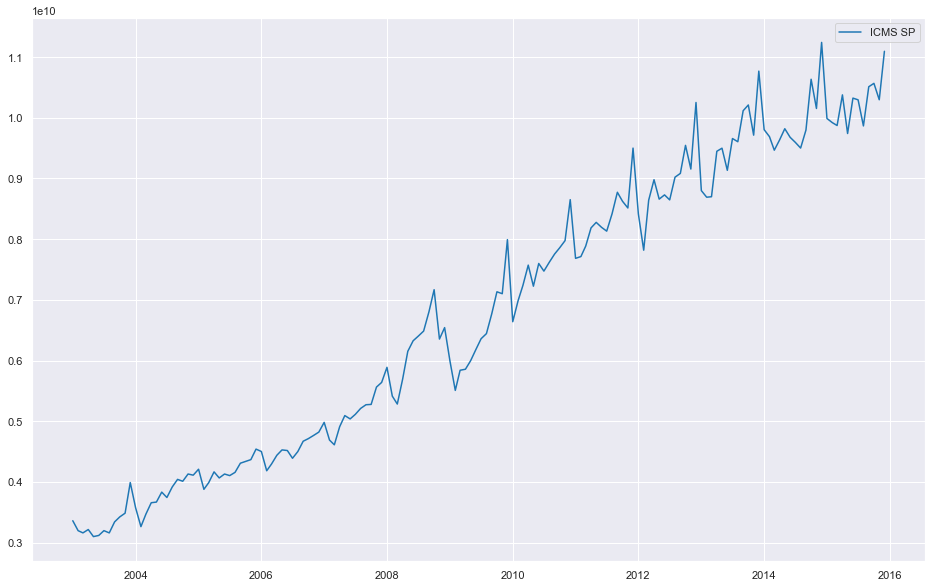

In [13]:
fig=plt.figure(figsize=(16, 10))
ax1=fig.add_subplot(111)
#plots
ax1.plot(icms_ts, 'tab:blue', label='ICMS SP')
ax1.legend(loc='best')
plt.show()

#### Últimos 24 meses da série

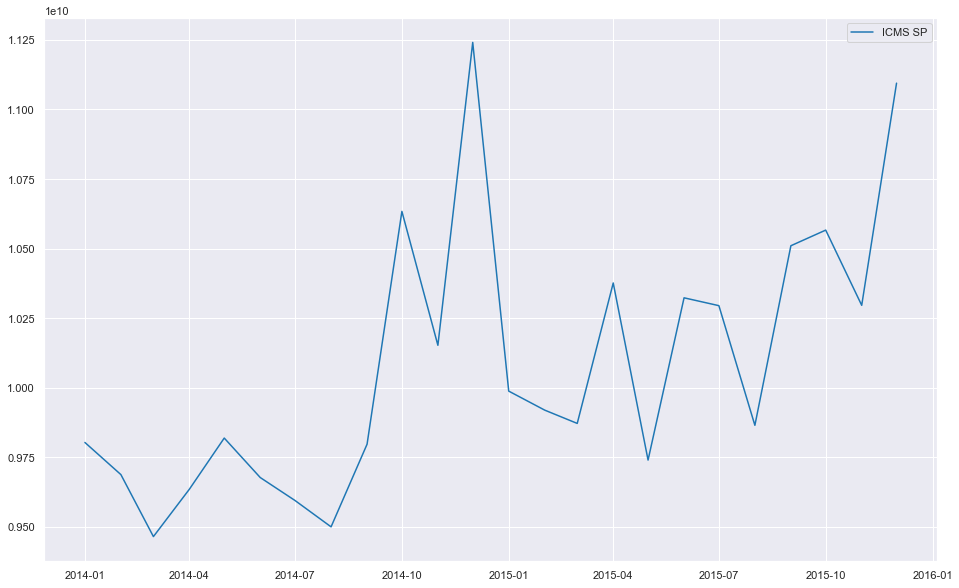

In [14]:
fig=plt.figure(figsize=(16, 10))
ax1=fig.add_subplot(111)
#plots
ax1.plot(icms_ts['2014-01-01':'2015-12-01'], 'tab:blue', label='ICMS SP')
ax1.legend(loc='best')
plt.show()

### Série em Log
Como os valores do ICMS são muito elevados a série será colocada em log.

In [15]:
l_icms_ts = pd.Series(np.log(list(df_main['icms_sp'])), index = datas)

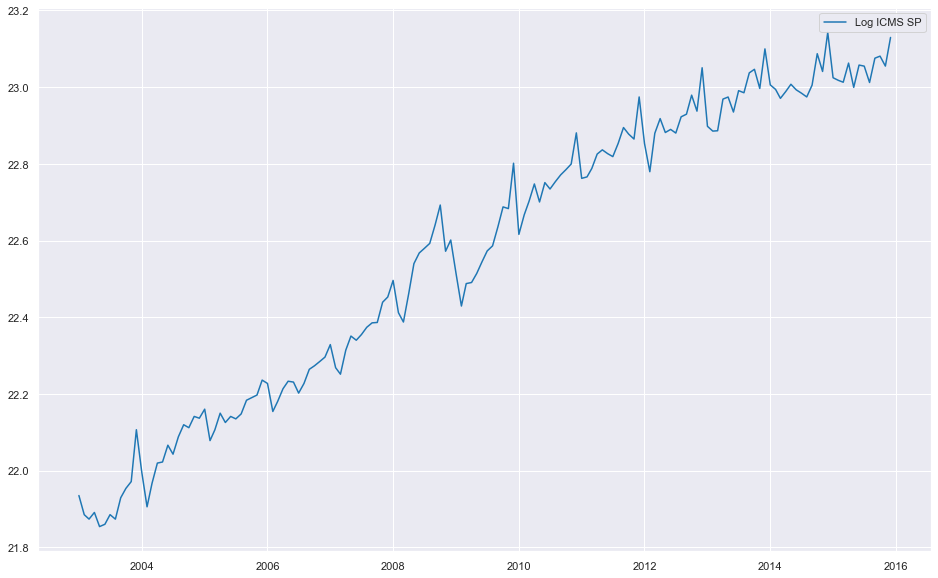

In [16]:
fig=plt.figure(figsize=(16, 10))
ax1=fig.add_subplot(111)
#plots
ax1.plot(l_icms_ts, 'tab:blue', label='Log ICMS SP')
ax1.legend(loc='best')
plt.show()

### Série em Primeira Diferença

In [17]:
icms_ts_d1 = icms_ts.diff().dropna()
l_icms_ts_d1 = l_icms_ts.diff().dropna()

### Plotando as Séries em Primeira Diferença

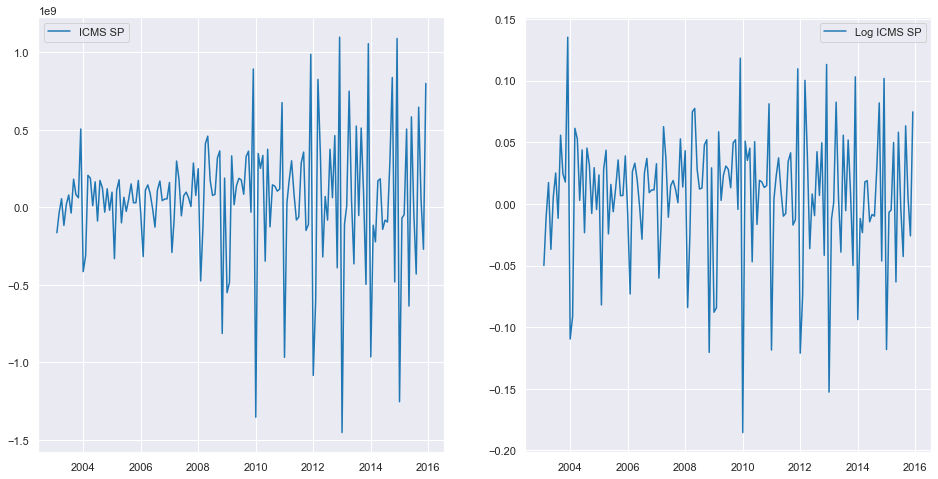

In [18]:
fig=plt.figure(figsize=(16, 8))
ax1=fig.add_subplot(121)
ax1.plot(icms_ts_d1, 'tab:blue', label='ICMS SP')
ax1.legend(loc='best')
ax2=fig.add_subplot(122)
ax2.plot(l_icms_ts_d1, 'tab:blue', label='Log ICMS SP')
ax2.legend(loc='best')
plt.show()

### Teste de Raiz Unitária da Série em Nível

Teste de raiz unitária Dickey-Fuller Aumentado (ADF): a hipótese nula é de que há raiz unitária e a série não é estacionária; a alternativa, de que não há e, portanto, a série é estacionária. 

Teste de raiz unitária Kwiatkowski-Phillips-Schmidt-Shin (KPSS): a hipótese nula é de que a série é de tendência estacionária; a alternativa é de há raiz unitária e a série não é estacionária.

A combinação dos dois testes pode ter os seguintes resultados com as seguintes consequências:

- Caso 1: Ambos os testes concluem que a série não é estacionária, então a série não é estacionária
- Caso 2: Ambos os testes concluem que a série é estacionária, então a série é estacionária
- Caso 3: o KPSS indica estacionariedade e o ADF indica não estacionariedade; a série é estacionária de tendência. A tendência precisa ser removida para tornar a série estritamente estacionária. A série sem tendência deve ser verificada quanto à estacionariedade.
- Caso 4: KPSS indica não estacionariedade e ADF indica estacionariedade; a série é estacionária diferencial. A diferenciação deve ser usada para tornar as séries estacionárias. A série diferenciada deve ser verificada quanto à estacionariedade.

**Fonte**: [Statsmodel](https://www.statsmodels.org/stable/examples/notebooks/generated/stationarity_detrending_adf_kpss.html)

In [19]:
from statsmodels.tsa.stattools import adfuller, kpss

def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

In [20]:
adf_test(l_icms_ts)

Results of Dickey-Fuller Test:
Test Statistic                  -2.351998
p-value                          0.155745
#Lags Used                      13.000000
Number of Observations Used    142.000000
Critical Value (1%)             -3.477262
Critical Value (5%)             -2.882118
Critical Value (10%)            -2.577743
dtype: float64


In [21]:
kpss_test(l_icms_ts)

Results of KPSS Test:
Test Statistic           1.817168
p-value                  0.010000
Lags Used                8.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


Série do ICMS em nível: a 5%, não rejeita-se a nula do teste ADF e rejeita-se do teste KPSS. A série não é estacionária e precisa ser posta em primeira diferença.

### Teste de Raiz Unitária da Série em Primeira Diferença
A série posta em primeira diferença será testadas para estacionariedade com os testes ADF e KPSS.

In [22]:
adf_test(l_icms_ts_d1)

Results of Dickey-Fuller Test:
Test Statistic                  -3.434885
p-value                          0.009826
#Lags Used                      12.000000
Number of Observations Used    142.000000
Critical Value (1%)             -3.477262
Critical Value (5%)             -2.882118
Critical Value (10%)            -2.577743
dtype: float64


In [23]:
kpss_test(l_icms_ts_d1)

Results of KPSS Test:
Test Statistic            0.104577
p-value                   0.100000
Lags Used                17.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


Série do ICMS em primeira diferença: a 5%, rejeita-se a nula do teste ADF e não se rejeita a nula do teste KPSS. A série é estacionária em ambos os testes e pode se usada em primeira diferença.

In [24]:
# Estimate the number of differences using an ADF test:
n_adf = ndiffs(l_icms_ts, test='adf')  # -> 0

# Or a KPSS test (auto_arima default):
n_kpss = ndiffs(l_icms_ts, test='kpss')  # -> 0

# Or a PP test:
n_pp = ndiffs(l_icms_ts, test='pp')  # -> 0
n_adf, n_kpss, n_pp

(1, 1, 0)

### Dessazonalização da Série

In [25]:
sns.set(rc={'figure.figsize':(15,7)})

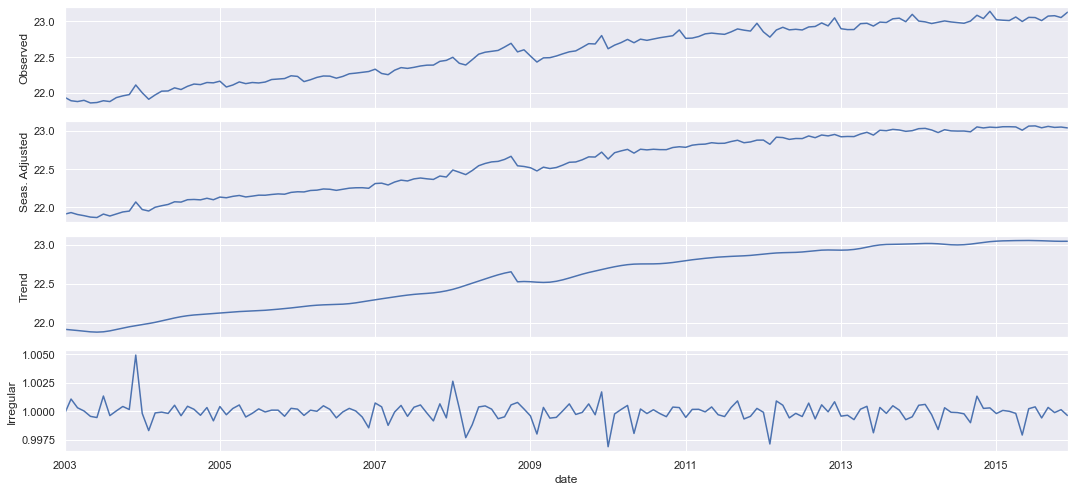

In [26]:
l_seas_icms = statsmodels.tsa.x13.x13_arima_analysis(l_icms_ts, x12path='./x13asmac/')
plot = l_seas_icms.plot()

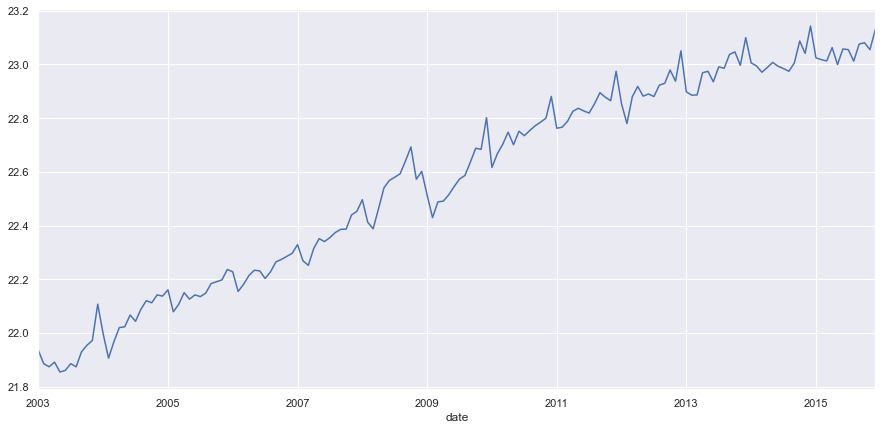

In [27]:
plot = l_seas_icms.observed.plot()

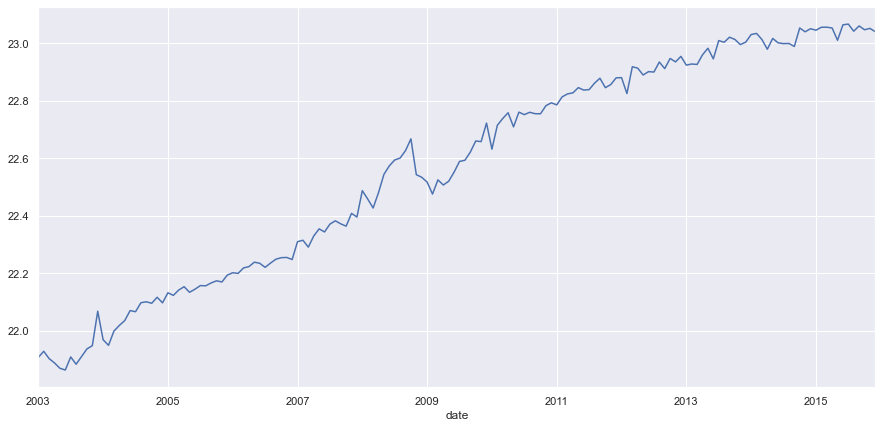

In [28]:
plot = l_seas_icms.seasadj.plot()

In [29]:
icms_decomp = pd.DataFrame(data={'ICMS observado': l_seas_icms.observed, 
                                 'ICMS desazonalizado': l_seas_icms.seasadj})

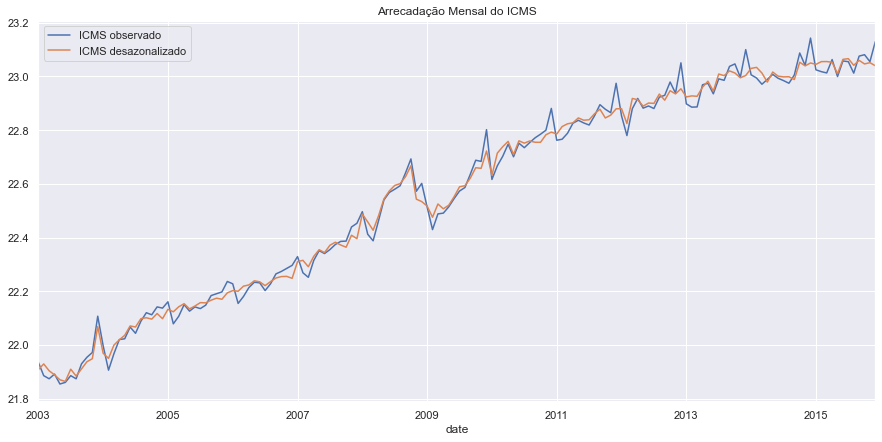

In [30]:
plot = icms_decomp.plot(title='Arrecadação Mensal do ICMS')

## Criando dummies de intervenção
Resultados do X13 Arima Seats para outliers e sazonalidade

In [31]:
pos = l_seas_icms.results.find('Outliers')
print(l_seas_icms.results[pos-309:pos+2105])

 ------------------------------------------------------------------------------
                             Parameter        Standard
 Variable                     Estimate           Error      t-value
 ------------------------------------------------------------------------------
 Automatically Identified Outliers
   AO2003.Dec                   0.0048         0.00117         4.08
   LS2008.Nov                  -0.0062         0.00116        -5.33
 ------------------------------------------------------------------------------


 ARIMA Model:  (1 1 0)(1 1 1)
   Nonseasonal differences: 1
   Seasonal differences:    1
                                              Standard
 Parameter                    Estimate          Errors
 -----------------------------------------------------
 Nonseasonal AR                                    
   Lag  1                      -0.4640         0.06970

 Seasonal AR                                       
   Lag 12                       0.4169         0.

In [32]:
ao2003dez = pd.Series(np.zeros(icms_ts.shape[0]), 
                      index=pd.date_range(start="2003-01-01", periods=icms_ts.shape[0], freq="MS"))
dt_final = str(ao2003dez.index[-1])

ao2003dez['2003-12-01'] = 1

ls2008nov = pd.Series(np.zeros(icms_ts.shape[0]), 
                      index=pd.date_range(start="2003-01-01", periods=icms_ts.shape[0], freq="MS"))
ls2008nov['2008-11-01':dt_final] = 1

In [33]:
ao2003dez.shape, ls2008nov.shape

((156,), (156,))

In [34]:
dummies_df = pd.DataFrame((ao2003dez, ls2008nov), 
                           index=['ao2003dez', 'ls2008nov']).transpose()
dummies_df.head()

,ao2003dez,ls2008nov
2003-01-01,0.0,0.0
2003-02-01,0.0,0.0
2003-03-01,0.0,0.0
2003-04-01,0.0,0.0
2003-05-01,0.0,0.0


In [35]:
dummies_df.tail()

,ao2003dez,ls2008nov
2015-08-01,0.0,1.0
2015-09-01,0.0,1.0
2015-10-01,0.0,1.0
2015-11-01,0.0,1.0
2015-12-01,0.0,1.0


### Teste de Raiz Unitária Sazonal

In [36]:
D = nsdiffs(icms_ts, m=12, max_D=12, test='ch')
D

0

In [37]:
D = nsdiffs(icms_ts, m=12, max_D=12, test='ocsb')
D

0

### Separando a amostra em treinamento (in-sample) e teste (out-of-sample)
Será usada a série em log, com sazonalidade e em nível. O modelo SARIMA irá lidar com a sazonalidade e a não estacionariedade. A série out-of-sample não vai estar em log para que o resultado seja real.

In [38]:
icms_train = l_icms_ts[:-12]
icms_test = icms_ts[-12:]

In [39]:
icms_train

date
2003-01-01    21.935295
2003-02-01    21.885340
2003-03-01    21.873841
2003-04-01    21.891189
2003-05-01    21.854323
                ...    
2014-08-01    22.974564
2014-09-01    23.005339
2014-10-01    23.087287
2014-11-01    23.040980
2014-12-01    23.142818
Length: 144, dtype: float64

In [40]:
icms_test

date
2015-01-01    9.987825e+09
2015-02-01    9.919477e+09
2015-03-01    9.871727e+09
2015-04-01    1.037640e+10
2015-05-01    9.740006e+09
2015-06-01    1.032307e+10
2015-07-01    1.029487e+10
2015-08-01    9.864942e+09
2015-09-01    1.051019e+10
2015-10-01    1.056639e+10
2015-11-01    1.029608e+10
2015-12-01    1.109438e+10
dtype: float64

In [41]:
dummies = dummies_df[:].to_numpy()
dummies_train = dummies[:-12]
dummies_test = dummies[-12:]
print(dummies.shape, dummies_train.shape, dummies_test.shape)
#print(dummies_train, dummies_test)

(156, 2) (144, 2) (12, 2)


## Utilidades para Previsões

Além de MAPE e MSE, será usado o erro relativo, que é 

$Erro Relativo = \frac{|previsão - real|}{real}$

In [42]:
def erro_relativo(prev, real):
    return 100*np.absolute(prev-real)/real

#### Dicionário de Previsões
Será usado para armazenar todas as previsões.

In [43]:
previsoes = {
    'nome':[],
    'modelo': [],
    'previsoes': [],
    'rmse': [],
    'mape': [],
    'erro relativo':[]
}

## Modelos Baseline
A média e a média móvel 12 meses do ano anterior (2014) serão usadas como o baseline da previsão como modelos naïve.

### Média

In [44]:
y_mean_pred = pd.Series(np.ones(12) * icms_ts[-24:-12].mean())
y_mean_pred.index = icms_test.index
y_mean_pred

date
2015-01-01    9.917198e+09
2015-02-01    9.917198e+09
2015-03-01    9.917198e+09
2015-04-01    9.917198e+09
2015-05-01    9.917198e+09
2015-06-01    9.917198e+09
2015-07-01    9.917198e+09
2015-08-01    9.917198e+09
2015-09-01    9.917198e+09
2015-10-01    9.917198e+09
2015-11-01    9.917198e+09
2015-12-01    9.917198e+09
dtype: float64

In [45]:
previsoes['nome'].append('Mean')
previsoes['modelo'].append(None)
previsoes['previsoes'].append(y_mean_pred)

In [46]:
RMSE_mean = mean_squared_error(icms_test, y_mean_pred, squared=False)
previsoes['rmse'].append(RMSE_mean)
RMSE_mean

488348874.923802

In [47]:
MAPE_mean = mean_absolute_percentage_error(icms_test, y_mean_pred)
previsoes['mape'].append(MAPE_mean)
MAPE_mean

0.03470150452943014

In [48]:
previsoes['erro relativo'].append([erro_relativo(prev,real) 
                                   for prev,real in zip(y_mean_pred, icms_test)])

### Comparação do modelo naïve com o real

In [49]:
prev_naive_df = pd.DataFrame(data={"Mean": previsoes['previsoes'][0]})
prev_naive_df['real'] = icms_test
prev_naive_df

,Mean,real
date,,
2015-01-01,9.917198e+09,9.987825e+09
2015-02-01,9.917198e+09,9.919477e+09
2015-03-01,9.917198e+09,9.871727e+09
2015-04-01,9.917198e+09,1.037640e+10
2015-05-01,9.917198e+09,9.740006e+09
2015-06-01,9.917198e+09,1.032307e+10
2015-07-01,9.917198e+09,1.029487e+10
2015-08-01,9.917198e+09,9.864942e+09
2015-09-01,9.917198e+09,1.051019e+10


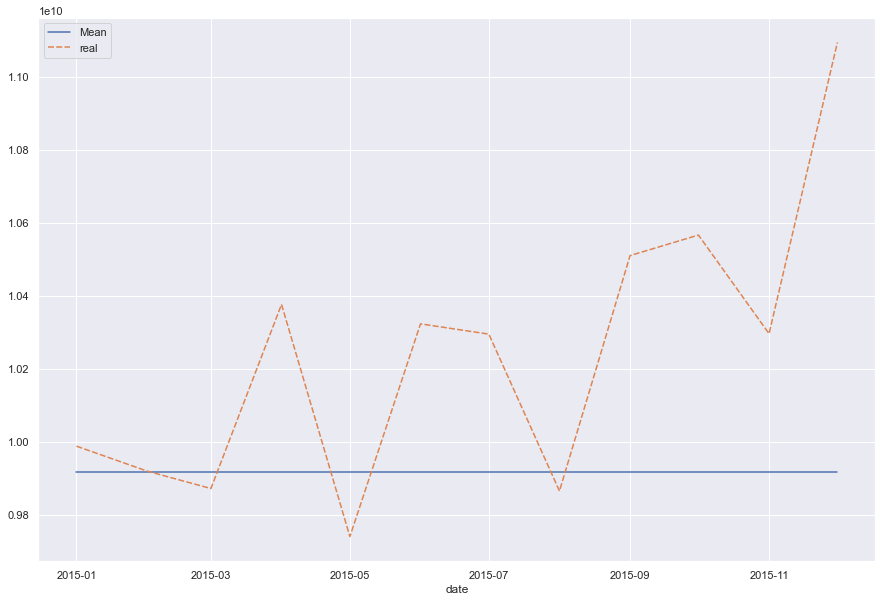

In [50]:
fig = plt.figure(figsize=(15, 10))
ax = sns.lineplot(data=prev_naive_df)

## Modelos ARIMA sem Dummies de Intervenção

### Auto Arima da Série

#### Critério de Akaike

In [51]:
mod_aa_aic = auto_arima(icms_train, stationary=False, seasonal=True, m=12, 
                        information_criterion='aic', test='kpss', seasonal_test='ocsb', stepewise=True)
mod_aa_aic

ARIMA(order=(0, 1, 1), scoring_args={}, seasonal_order=(1, 0, 1, 12),
      suppress_warnings=True, with_intercept=False)

#### Critério de Schwarz

In [52]:
mod_aa_bic = auto_arima(icms_train, stationary=False, seasonal=True, m=12,
                        information_criterion='bic', test='kpss', seasonal_test='ocsb', stepewise=True)
mod_aa_bic

ARIMA(order=(0, 1, 1), scoring_args={}, seasonal_order=(1, 0, 1, 12),
      suppress_warnings=True, with_intercept=False)

### Modelo SARIMA(0,1,1),(1,0,1) sugerido pelo critério de Akaike e Schwarz

In [53]:
mod_arima1 = ARIMA(icms_train, order=(0,1,1), seasonal_order=(1,0,1,12))
res_arima1 = mod_arima1.fit()
print(res_arima1.summary())

                                    SARIMAX Results                                     
Dep. Variable:                                y   No. Observations:                  144
Model:             ARIMA(0, 1, 1)x(1, 0, 1, 12)   Log Likelihood                 261.123
Date:                          Mon, 03 Jul 2023   AIC                           -514.247
Time:                                  13:00:44   BIC                           -502.396
Sample:                              01-01-2003   HQIC                          -509.431
                                   - 12-01-2014                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4039      0.063     -6.447      0.000      -0.527      -0.281
ar.S.L12       0.9559      0.036     26.721      0.

#### Análise dos Resíduos

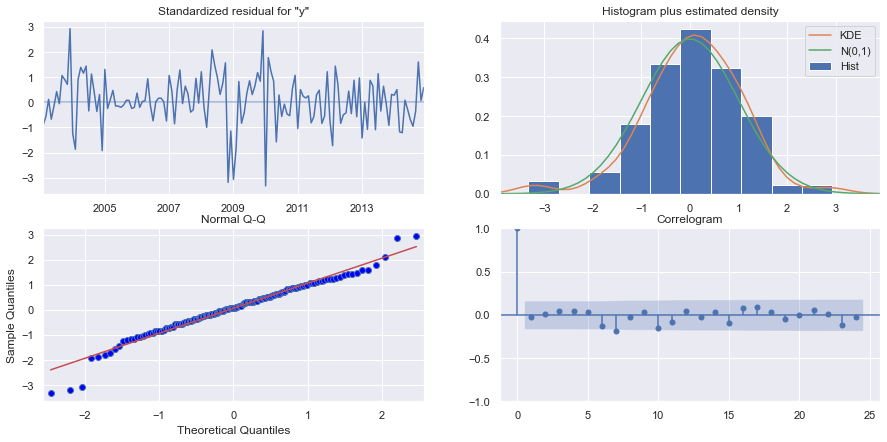

In [54]:
ax = res_arima1.plot_diagnostics(lags=24)

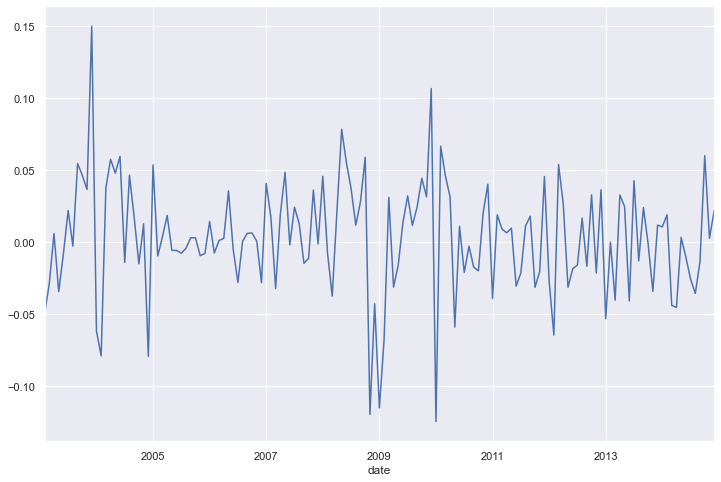

In [55]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax = res_arima1.resid[1:].plot(ax=ax)

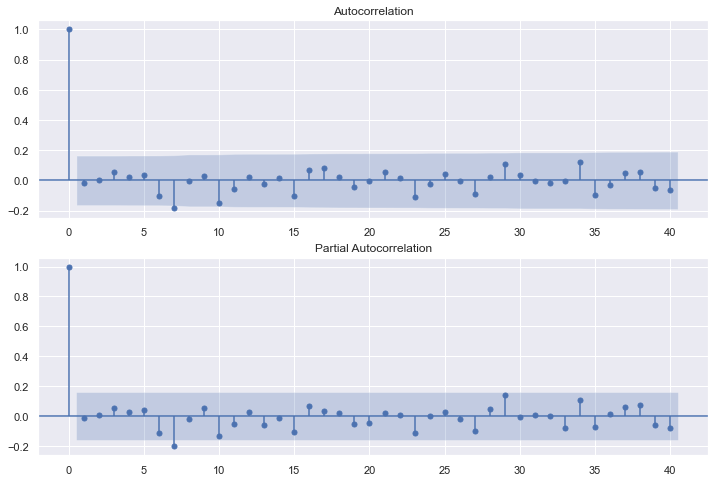

In [56]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(res_arima1.resid[1:].values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(res_arima1.resid[1:], lags=40, ax=ax2)

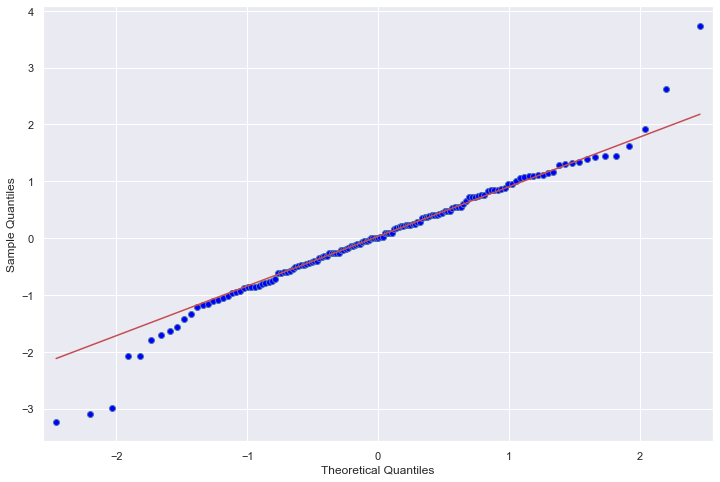

In [57]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
fig = qqplot(res_arima1.resid[1:], line="q", ax=ax, fit=True)

#### Previsões

In [58]:
previsoes['nome'].append('SARIMA(0,1,1),(1,0,1)')
previsoes['modelo'].append(res_arima1)

In [59]:
y_arima1_pred = np.exp(res_arima1.forecast(12))
previsoes['previsoes'].append(y_arima1_pred)

In [60]:
RMSE_arima1 = mean_squared_error(icms_test, y_arima1_pred, squared=False)
previsoes['rmse'].append(RMSE_arima1)
RMSE_arima1

466293002.3922289

In [61]:
MAPE_arima1 = mean_absolute_percentage_error(icms_test, y_arima1_pred)
previsoes['mape'].append(MAPE_arima1)
MAPE_arima1

0.036178991108906405

In [62]:
previsoes['erro relativo'].append([erro_relativo(prev,real) 
                                   for prev,real in zip(y_arima1_pred, icms_test)])

#### Comparação com o Real

In [63]:
prev_arma_df = pd.DataFrame(data={previsoes['nome'][1]: previsoes['previsoes'][1]})
prev_arma_df['real'] = icms_test
prev_arma_df

,"SARIMA(0,1,1),(1,0,1)",real
2015-01-01,1.014584e+10,9.987825e+09
2015-02-01,9.931784e+09,9.919477e+09
2015-03-01,1.006162e+10,9.871727e+09
2015-04-01,1.042939e+10,1.037640e+10
2015-05-01,1.046458e+10,9.740006e+09
2015-06-01,1.040369e+10,1.032307e+10
2015-07-01,1.047142e+10,1.029487e+10
2015-08-01,1.055323e+10,9.864942e+09
2015-09-01,1.085996e+10,1.051019e+10
2015-10-01,1.123203e+10,1.056639e+10


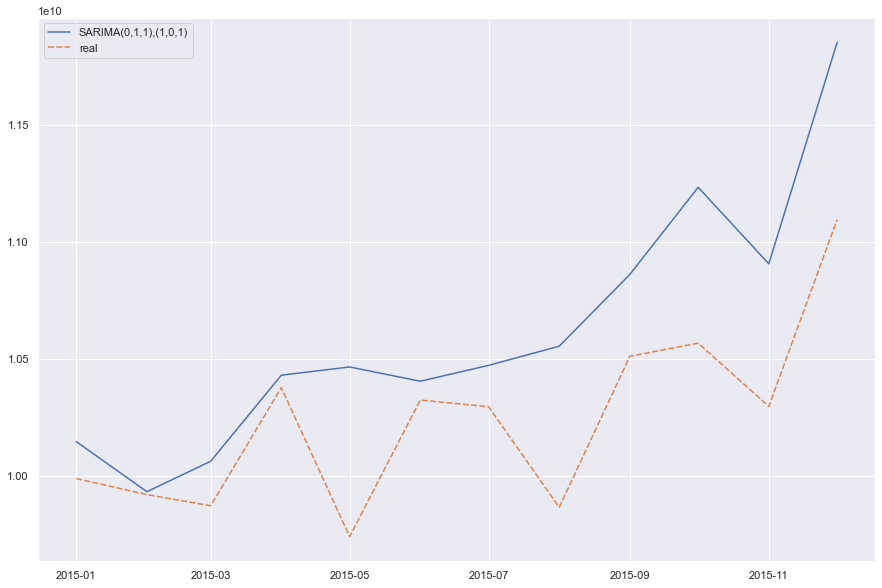

In [64]:
fig = plt.figure(figsize=(15, 10))
ax = sns.lineplot(data=prev_arma_df)

## Modelos ARIMA com Dummies de Intervenção

### Auto Arima da Série

#### Critério de Akaike

In [65]:
mod_aa_aic_dum = auto_arima(icms_train, X=dummies_train, d=1, stationary=False, seasonal=True, m=12, 
                        information_criterion='aic', test='kpss', seasonal_test='ocsb', stepewise=True)
mod_aa_aic_dum

ARIMA(order=(0, 1, 1), scoring_args={}, seasonal_order=(1, 0, 1, 12),
      suppress_warnings=True)

#### Critério de Schwarz

In [66]:
mod_aa_bic_dum = auto_arima(icms_train, x=dummies_train, d=1, stationary=False, seasonal=True, m=12, 
                        information_criterion='bic', test='kpss', seasonal_test='ocsb', stepewise=True)
mod_aa_bic_dum

ARIMA(order=(0, 1, 1), scoring_args={}, seasonal_order=(1, 0, 1, 12),
      suppress_warnings=True, with_intercept=False)

### Modelo SARIMAX(0,1,1),(1,0,1) sugerido pelos critérios de Akaike e Schwarz
Mesmo modelo sugerido para a série sem as dummies de intervenção.

In [67]:
mod_arima3 = ARIMA(icms_train, exog=dummies_train, order=(0,1,1), seasonal_order=(1,0,1,12))
res_arima3 = mod_arima3.fit()
print(res_arima3.summary())

                                    SARIMAX Results                                     
Dep. Variable:                                y   No. Observations:                  144
Model:             ARIMA(0, 1, 1)x(1, 0, 1, 12)   Log Likelihood                 280.311
Date:                          Mon, 03 Jul 2023   AIC                           -548.622
Time:                                  13:01:51   BIC                           -530.845
Sample:                              01-01-2003   HQIC                          -541.398
                                   - 12-01-2014                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1279      0.061      2.092      0.036       0.008       0.248
x2            -0.1397      0.035     -4.014      0.

#### Análise dos Resíduos

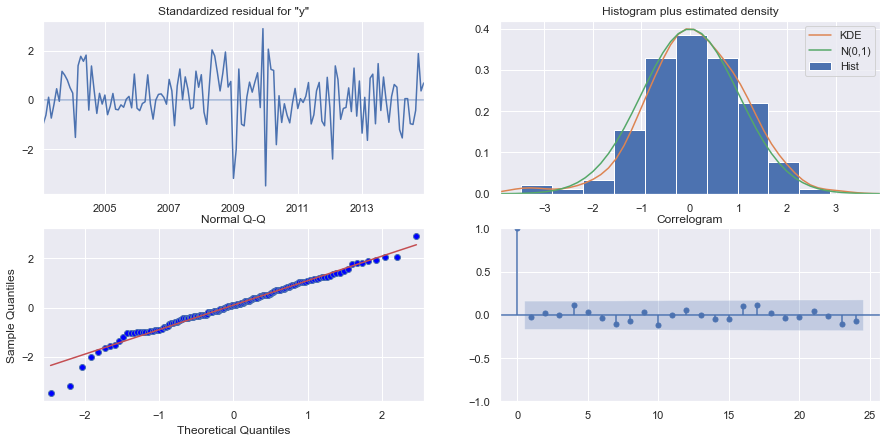

In [68]:
ax = res_arima3.plot_diagnostics(lags=24)

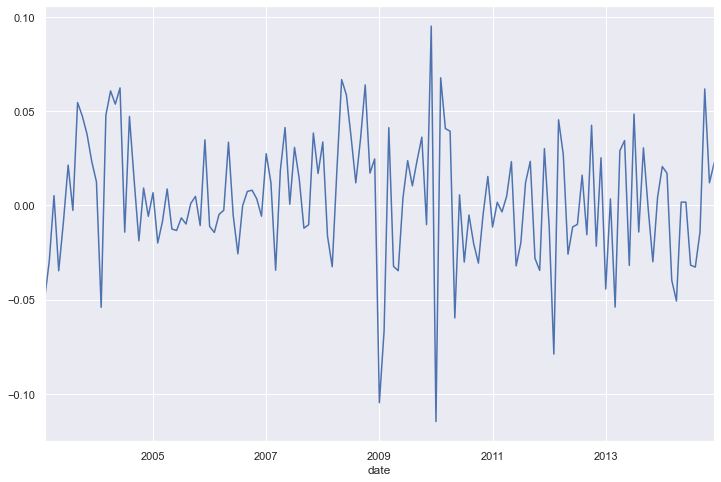

In [69]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax = res_arima3.resid[1:].plot(ax=ax)

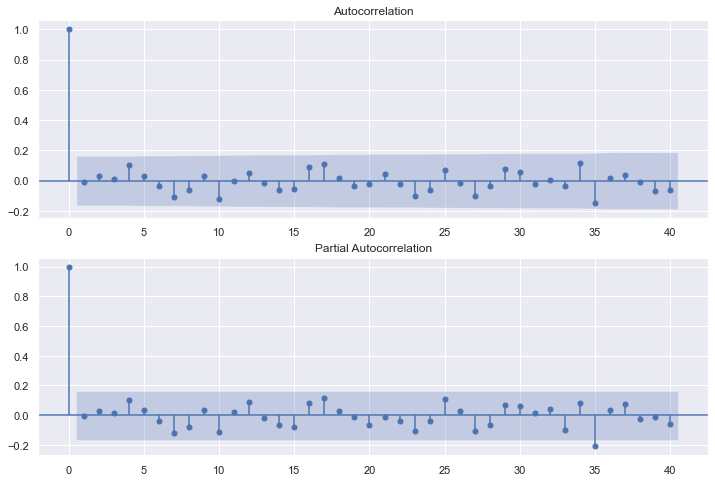

In [70]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(res_arima3.resid[1:].values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(res_arima3.resid[1:], lags=40, ax=ax2)

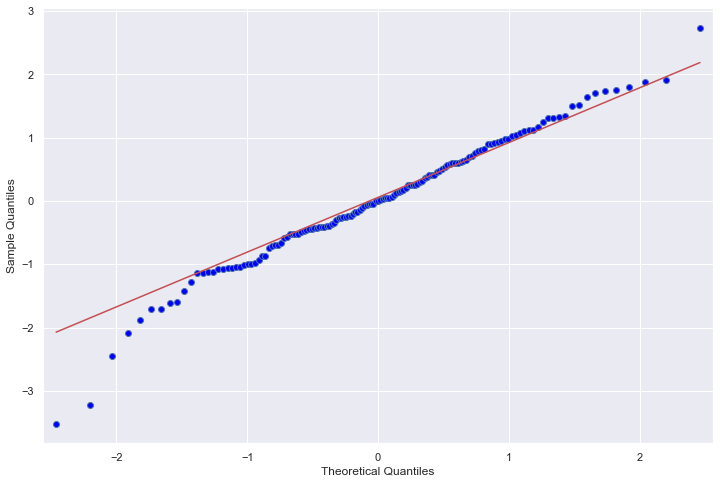

In [71]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
fig = qqplot(res_arima3.resid[1:], line="q", ax=ax, fit=True)

### Previsões

In [72]:
previsoes['nome'].append('SARIMAX(0,1,1),(1,0,1)')
previsoes['modelo'].append(res_arima3)

In [73]:
y_arima3_pred = np.exp(res_arima3.forecast(12, exog=dummies_test))
previsoes['previsoes'].append(y_arima3_pred)

In [74]:
RMSE_arima3 = mean_squared_error(icms_test, y_arima3_pred, squared=False)
previsoes['rmse'].append(RMSE_arima3)
RMSE_arima3

338300318.86132896

In [75]:
MAPE_arima3 = mean_absolute_percentage_error(icms_test, y_arima3_pred)
previsoes['mape'].append(MAPE_arima3)
MAPE_arima3

0.025730706351331872

In [76]:
previsoes['erro relativo'].append([erro_relativo(prev,real) 
                                   for prev,real in zip(y_arima3_pred, icms_test)])

### Comparação dos modelos SARIMA

In [77]:
prev_arma_df = pd.DataFrame(data={previsoes['nome'][1]: previsoes['previsoes'][1],
                                 previsoes['nome'][2]: previsoes['previsoes'][2]})
prev_arma_df['real'] = icms_test
prev_arma_df

,"SARIMA(0,1,1),(1,0,1)","SARIMAX(0,1,1),(1,0,1)",real
2015-01-01,1.014584e+10,1.016678e+10,9.987825e+09
2015-02-01,9.931784e+09,1.002613e+10,9.919477e+09
2015-03-01,1.006162e+10,1.001289e+10,9.871727e+09
2015-04-01,1.042939e+10,1.031545e+10,1.037640e+10
2015-05-01,1.046458e+10,1.038969e+10,9.740006e+09
2015-06-01,1.040369e+10,1.025233e+10,1.032307e+10
2015-07-01,1.047142e+10,1.031148e+10,1.029487e+10
2015-08-01,1.055323e+10,1.030290e+10,9.864942e+09
2015-09-01,1.085996e+10,1.058810e+10,1.051019e+10
2015-10-01,1.123203e+10,1.107234e+10,1.056639e+10


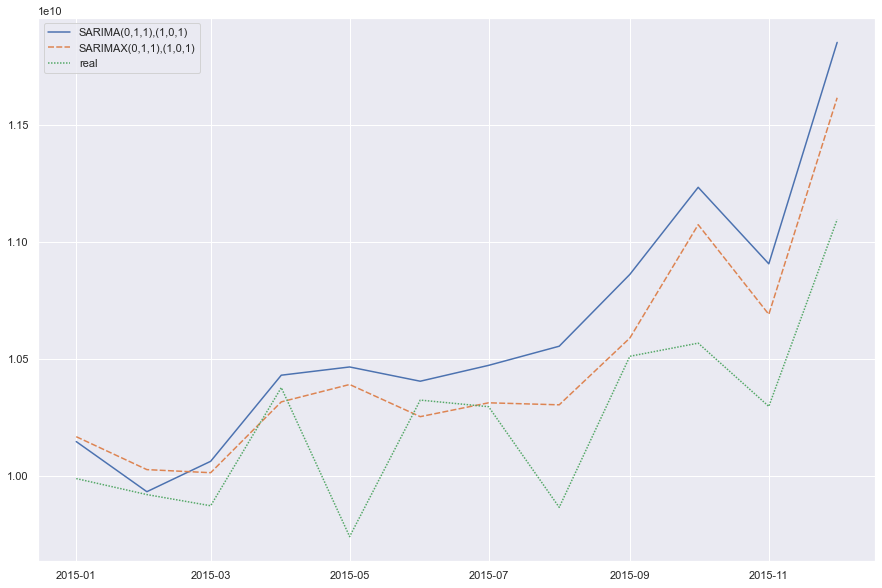

In [78]:
fig = plt.figure(figsize=(15, 10))
ax = sns.lineplot(data=prev_arma_df)

## Modelo de Markov-Switching

A biblioteca statsmodel não tem implementado o método de forecast do modelo de Markov Switching. Por isso o forecast foi realizado no Ox e os dados estão sendo importados aqui.
Foram feitos 3 modelos usando as mesmas variáveis e 2 mudanças de regime:
- log icms em primeira diferença - Y
- constante - mudança de regime (*regime switching*)
- loc icms em primeira diferença com uma defasagem - (*regime switching*) 
- 11 dummies sazonais - X (variável)

E foram usados 3 tipos de variância
- variância fixa (*fixed variance*)
- mudança de variância (*switching variance*)
- componente média-variância (*mean-variance component*)

In [79]:
markov_forecast_df = pd.read_csv('forecast_markov.csv', delimiter=';', decimal=',')
markov_forecast_df = markov_forecast_df[-96:-84]
markov_forecast_df.tail()

,Unnamed: 0,date,icms_sp,igp_m,ibc_br,dias_uteis,Licms_sp,DLicms_sp,D2igp_m,Dibc_br,...,15_forecast_multi_var,15_forecast_multi_mean_var,14_forecast_uni_fixed,14_forecast_uni_var,14_forecast_multi_var,13_forecast_uni_fixed,13_forecast_uni_var,13_forecast_uni_mean_var,13_forecast_multi_var,13_forecast_multi_mean_var
151,2015(8),2015-08-01,9864942434,588.042,140.83,21,23.012253,-0.042659,5.641,-2.32,...,0.000534,-0.001597,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
152,2015(9),2015-09-01,10510189119,593.606,138.07,21,23.075611,0.063358,7.180,-2.76,...,0.039900,0.035920,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
153,2015(10),2015-10-01,10566387057,604.832,140.19,21,23.080944,0.005333,16.790,2.12,...,0.027413,0.019496,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
154,2015(11),2015-11-01,10296081459,614.051,135.94,20,23.055029,-0.025915,20.445,-4.25,...,-0.005414,-0.012621,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
155,2015(12),2015-12-01,11094379336,617.044,136.22,22,23.129704,0.074675,12.212,0.28,...,0.114630,0.111515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Variância Fixa

In [80]:
arq1 = open('./ox/15_results_uni_fixed.txt', 'r')
print(arq1.read())
arq1.close()


Switching(28) Modelling DLicms_sp by MS(2)
              The dataset is: /Users/asbonato/mpe-fgv-eesp/_dissertacao/codigo/final/ox/variaveis_previsao.xlsx
              The estimation sample is: 2003-04-01 - 2014-12-01

                 Coefficient   Std.Error  t-value  t-prob
CSeasonal          -0.100389     0.01468    -6.84   0.000
CSeasonal_1        -0.151339     0.01421    -10.6   0.000
CSeasonal_2       -0.0485841     0.01405    -3.46   0.001
CSeasonal_3       -0.0117552     0.01337   -0.879   0.381
CSeasonal_4       -0.0436093     0.01368    -3.19   0.002
CSeasonal_5       -0.0555664     0.01318    -4.22   0.000
CSeasonal_6       -0.0589422     0.01322    -4.46   0.000
CSeasonal_7       -0.0455437     0.01319    -3.45   0.001
CSeasonal_8       -0.0225634     0.01328    -1.70   0.092
CSeasonal_9       -0.0281799     0.01357    -2.08   0.040
CSeasonal_10      -0.0648923     0.01341    -4.84   0.000
Constant(0)        0.0102860    0.003823     2.69   0.008
Constant(1)        0.0112

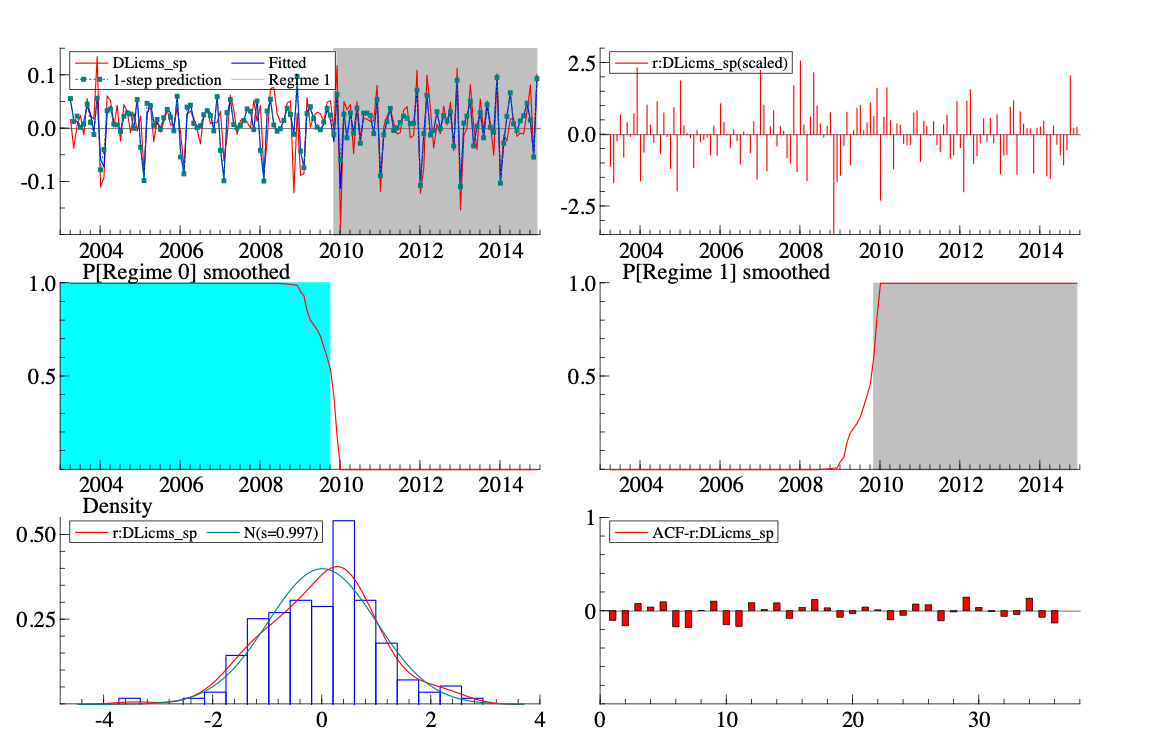

#### Previsões

In [81]:
y_markov_fixed_pred = np.exp(np.cumsum(markov_forecast_df['15_forecast_uni_fixed'])+icms_train[-1])
y_markov_fixed_pred.index = icms_test.index
y_markov_fixed_pred

date
2015-01-01    1.015299e+10
2015-02-01    9.929947e+09
2015-03-01    1.022763e+10
2015-04-01    1.057283e+10
2015-05-01    1.056222e+10
2015-06-01    1.065728e+10
2015-07-01    1.064873e+10
2015-08-01    1.085141e+10
2015-09-01    1.117332e+10
2015-10-01    1.136448e+10
2015-11-01    1.123024e+10
2015-12-01    1.206260e+10
Name: 15_forecast_uni_fixed, dtype: float64

In [82]:
previsoes['nome'].append('Markov-Fixed')
previsoes['modelo'].append(None)
previsoes['previsoes'].append(y_markov_fixed_pred)

In [83]:
RMSE_markov_fixed = mean_squared_error(icms_test, y_markov_fixed_pred, squared=False)
previsoes['rmse'].append(RMSE_markov_fixed)
RMSE_markov_fixed

643267074.0010262

In [84]:
MAPE_markov_fixed = mean_absolute_percentage_error(icms_test, y_markov_fixed_pred)
previsoes['mape'].append(MAPE_markov_fixed)
MAPE_markov_fixed

0.05336355585663407

In [85]:
previsoes['erro relativo'].append([erro_relativo(prev,real) 
                                   for prev,real in zip(y_markov_fixed_pred, icms_test)])

### Modelo com Mudança de Variância

In [86]:
arq2 = open('./ox/15_results_uni_var.txt', 'r')
print(arq2.read())
arq2.close()


Switching(29) Modelling DLicms_sp by MS(2)
              The dataset is: /Users/asbonato/mpe-fgv-eesp/_dissertacao/codigo/final/ox/variaveis_previsao.xlsx
              The estimation sample is: 2003-04-01 - 2014-12-01

                 Coefficient   Std.Error  t-value  t-prob
CSeasonal          -0.133064     0.01742    -7.64   0.000
CSeasonal_1        -0.149888     0.01335    -11.2   0.000
CSeasonal_2       -0.0754629     0.01313    -5.75   0.000
CSeasonal_3       -0.0242731     0.01425    -1.70   0.091
CSeasonal_4       -0.0548203     0.01400    -3.91   0.000
CSeasonal_5       -0.0697720     0.01308    -5.34   0.000
CSeasonal_6       -0.0737261     0.01381    -5.34   0.000
CSeasonal_7       -0.0570241     0.01170    -4.87   0.000
CSeasonal_8       -0.0322496     0.01218    -2.65   0.009
CSeasonal_9       -0.0448872     0.01397    -3.21   0.002
CSeasonal_10      -0.0765910     0.01507    -5.08   0.000
Constant(0)       0.00963832    0.004073     2.37   0.020
Constant(1)        0.0124

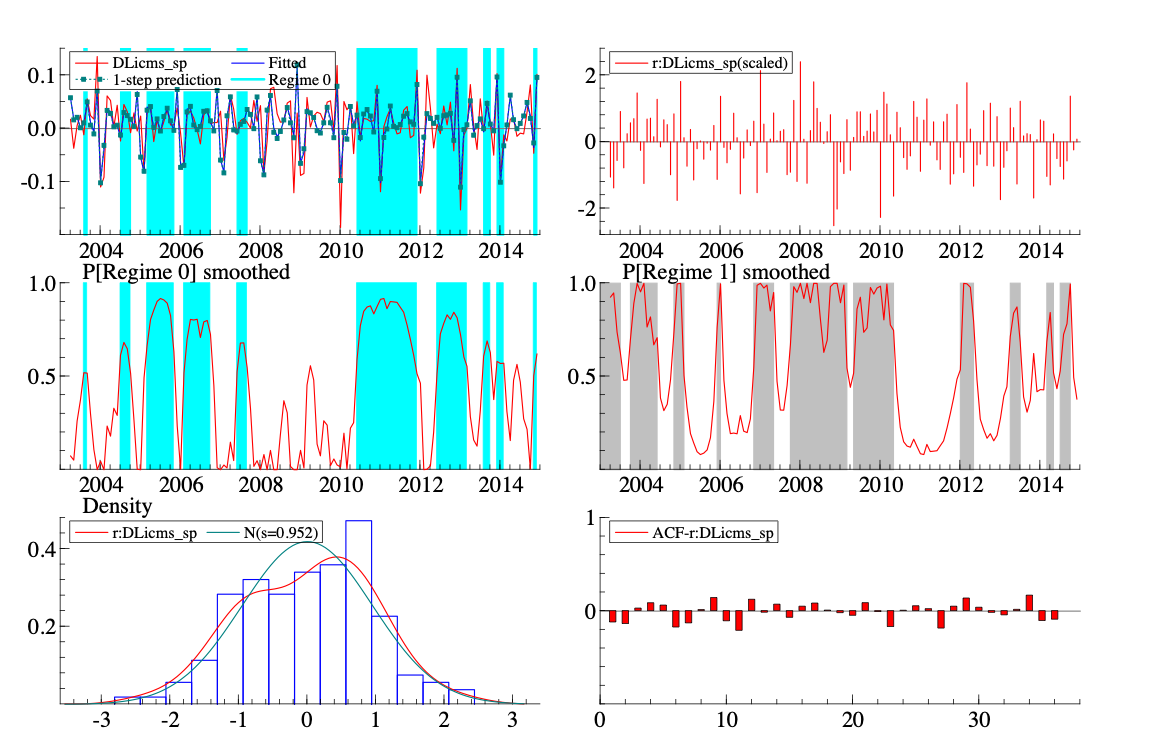

#### Previsões

In [87]:
y_markov_var_pred = np.exp(np.cumsum(markov_forecast_df['15_forecast_uni_var'])+icms_train[-1])
y_markov_var_pred.index = icms_test.index
y_markov_var_pred

date
2015-01-01    1.015288e+10
2015-02-01    9.867201e+09
2015-03-01    1.000460e+10
2015-04-01    1.048579e+10
2015-05-01    1.051246e+10
2015-06-01    1.057912e+10
2015-07-01    1.058757e+10
2015-08-01    1.079949e+10
2015-09-01    1.120277e+10
2015-10-01    1.139495e+10
2015-11-01    1.132117e+10
2015-12-01    1.226275e+10
Name: 15_forecast_uni_var, dtype: float64

In [88]:
previsoes['nome'].append('Markov-Switching-Var')
previsoes['modelo'].append(None)
previsoes['previsoes'].append(y_markov_var_pred)

In [89]:
RMSE_markov_var = mean_squared_error(icms_test, y_markov_var_pred, squared=False)
previsoes['rmse'].append(RMSE_markov_var)
RMSE_markov_var

662254354.0082462

In [90]:
MAPE_markov_var = mean_absolute_percentage_error(icms_test, y_markov_var_pred)
previsoes['mape'].append(MAPE_markov_var)
MAPE_markov_var

0.0518548863413122

In [91]:
previsoes['erro relativo'].append([erro_relativo(prev,real) 
                                   for prev,real in zip(y_markov_var_pred, icms_test)])

### Componente Média-Variância

In [92]:
arq3 = open('./ox/15_results_uni_mean_var.txt', 'r')
print(arq3.read())
arq3.close()


Switching(30) Modelling DLicms_sp by MS_Component(2, 2)
              The dataset is: /Users/asbonato/mpe-fgv-eesp/_dissertacao/codigo/final/ox/variaveis_previsao.xlsx
              The estimation sample is: 2003-04-01 - 2014-12-01

                 Coefficient   Std.Error  t-value  t-prob
CSeasonal          -0.105505     0.01141    -9.25   0.000
CSeasonal_1        -0.153820     0.01100    -14.0   0.000
CSeasonal_2       -0.0562256     0.01020    -5.51   0.000
CSeasonal_3       -0.0284476     0.01056    -2.69   0.008
CSeasonal_4       -0.0675958     0.01006    -6.72   0.000
CSeasonal_5       -0.0675771    0.009365    -7.22   0.000
CSeasonal_6       -0.0848347     0.01029    -8.24   0.000
CSeasonal_7       -0.0576486    0.009363    -6.16   0.000
CSeasonal_8       -0.0413892     0.01013    -4.09   0.000
CSeasonal_9       -0.0422837    0.009786    -4.32   0.000
CSeasonal_10      -0.0752909     0.01013    -7.44   0.000
Constant(0)        0.0161205    0.003235     4.98   0.000
Constant(1) 

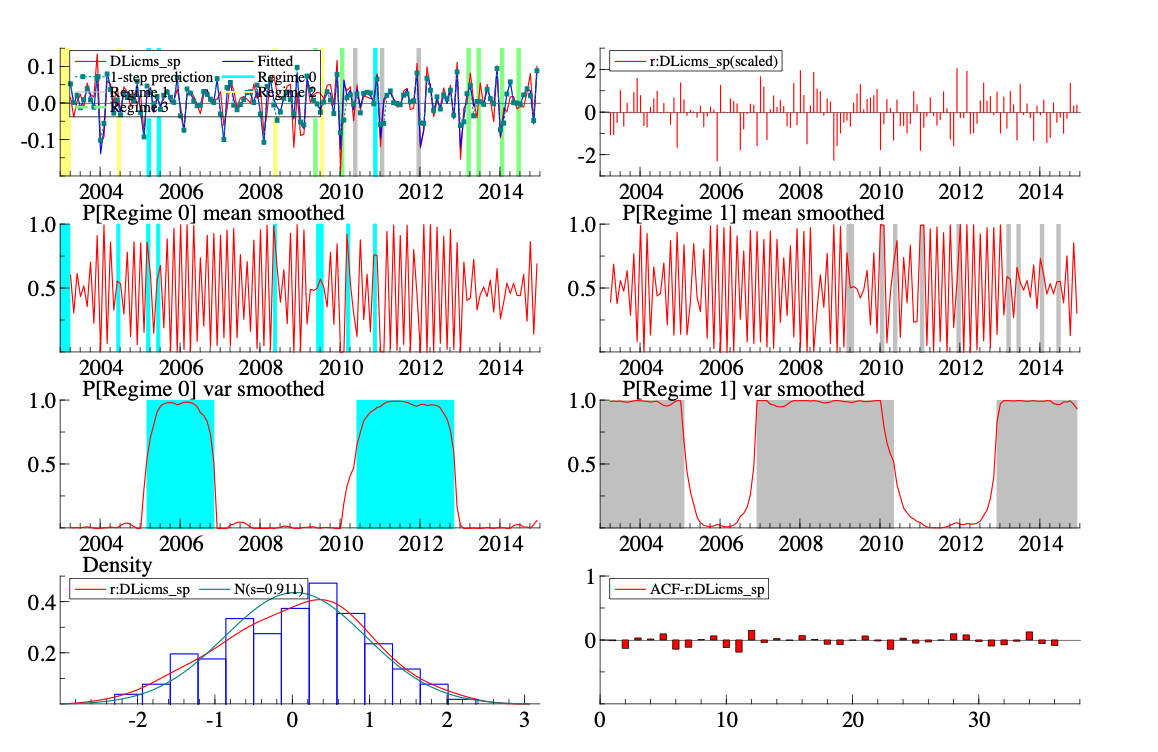

#### Previsões

In [93]:
y_markov_mean_var_pred = np.exp(np.cumsum(markov_forecast_df['15_forecast_uni_mean_var'])+icms_train[-1])
y_markov_mean_var_pred.index = icms_test.index
y_markov_mean_var_pred

date
2015-01-01    1.034930e+10
2015-02-01    9.863239e+09
2015-03-01    1.029537e+10
2015-04-01    1.064153e+10
2015-05-01    1.058740e+10
2015-06-01    1.071360e+10
2015-07-01    1.057784e+10
2015-08-01    1.084369e+10
2015-09-01    1.112272e+10
2015-10-01    1.140003e+10
2015-11-01    1.130573e+10
2015-12-01    1.225550e+10
Name: 15_forecast_uni_mean_var, dtype: float64

In [94]:
previsoes['nome'].append('Markov-Mean-Var')
previsoes['modelo'].append(None)
previsoes['previsoes'].append(y_markov_mean_var_pred)

In [95]:
RMSE_markov_mean_var = mean_squared_error(icms_test, y_markov_mean_var_pred, squared=False)
previsoes['rmse'].append(RMSE_markov_mean_var)
RMSE_markov_mean_var

691012228.4385957

In [96]:
MAPE_markov_mean_var = mean_absolute_percentage_error(icms_test, y_markov_mean_var_pred)
previsoes['mape'].append(MAPE_markov_mean_var)
MAPE_markov_mean_var

0.05847979832005928

In [97]:
previsoes['erro relativo'].append([erro_relativo(prev,real) 
                                   for prev,real in zip(y_markov_mean_var_pred, icms_test)])

#### Resultados dos Modelos de Markov

In [98]:
previsoes['nome']

['Mean',
 'SARIMA(0,1,1),(1,0,1)',
 'SARIMAX(0,1,1),(1,0,1)',
 'Markov-Fixed',
 'Markov-Switching-Var',
 'Markov-Mean-Var']

In [99]:
prev_markov_df = pd.DataFrame(data={previsoes['nome'][3]: previsoes['previsoes'][3],
                                    previsoes['nome'][4]: previsoes['previsoes'][4]
                                   })
prev_markov_df['real'] = icms_test
prev_markov_df

,Markov-Fixed,Markov-Switching-Var,real
date,,,
2015-01-01,1.015299e+10,1.015288e+10,9.987825e+09
2015-02-01,9.929947e+09,9.867201e+09,9.919477e+09
2015-03-01,1.022763e+10,1.000460e+10,9.871727e+09
2015-04-01,1.057283e+10,1.048579e+10,1.037640e+10
2015-05-01,1.056222e+10,1.051246e+10,9.740006e+09
2015-06-01,1.065728e+10,1.057912e+10,1.032307e+10
2015-07-01,1.064873e+10,1.058757e+10,1.029487e+10
2015-08-01,1.085141e+10,1.079949e+10,9.864942e+09
2015-09-01,1.117332e+10,1.120277e+10,1.051019e+10


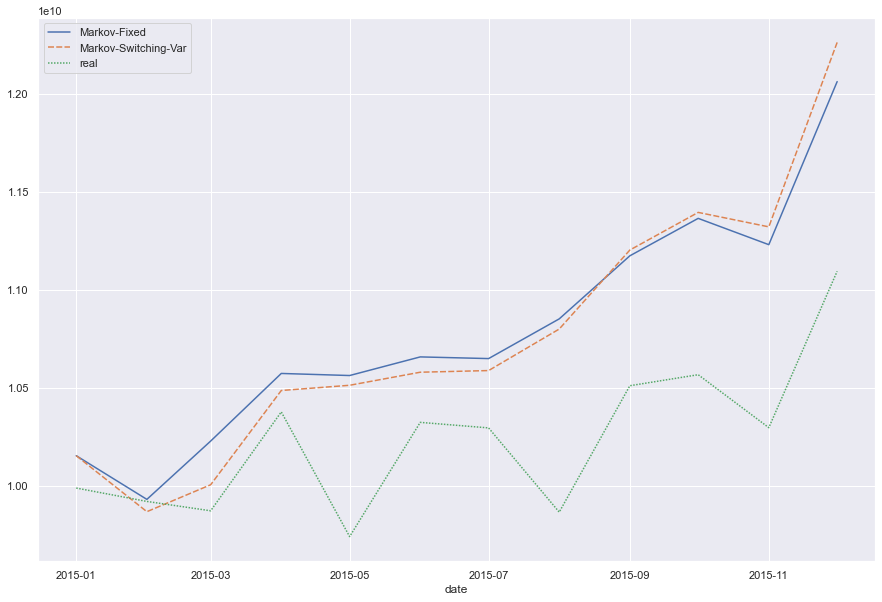

In [100]:
fig = plt.figure(figsize=(15, 10))
ax = sns.lineplot(data=prev_markov_df)

## Modelos RNN LSTM
Redes Neurais Recorrentes com neurônios Long Short-Term Memory

### Montagem da Série
As redes neurais precisam de conjuntos de características e de etiquetas separados. Neste caso, o conjunto de etiquetas é a própria série de ICMS. Para os conjunto de caraterísticas será utilizada a série do ICMS com lags 1, 2, 3, 4, 6 e 12 defasagens, e médias móveis de 2, 3, 6 e 12 meses, conforme trabalho de [Silva & Figueiredo, 2020].

In [101]:
def cria_features_target(serie, verbose=0):
    serie_d1 = serie.shift(1)
    serie_d2 = serie.shift(2)
    serie_d3 = serie.shift(3)
    serie_d4 = serie.shift(4)
    serie_d6 = serie.shift(6)
    serie_d12 = serie.shift(12)
    serie_ma2 = serie.rolling(2).mean()
    serie_ma3 = serie.rolling(3).mean()
    serie_ma6 = serie.rolling(6).mean()
    serie_ma12 = serie.rolling(12).mean()

    if verbose==1:
        print("shape de cada uma das séries:")
        print(serie_d1.shape, serie_d2.shape, serie_d3.shape, serie_d4.shape, 
              serie_d6.shape, serie_d12.shape, serie_ma2.shape, serie_ma3.shape, 
              serie_ma6.shape, serie_ma12.shape)
    X = np.array([serie_d1, serie_d2, serie_d3, serie_d4, 
     serie_d6, serie_d12, serie_ma2, serie_ma3, 
     serie_ma6, serie_ma12])
    if verbose==1:
        print("shape do array de features:", X.shape)
    X = X[:,12:]
    X = X.T
    if verbose==1:
        print("shape do array de features depois da poda e da transposição:", X.shape)
    Y = np.array(serie[12:])
    if verbose==1:
        print("shape do array target:", Y.shape)
    return X, Y

In [102]:
#série completa, com sazonalidade e em nível
#seas_icms_ts = seas_icms.seasadj
X_data, Y_data = cria_features_target(l_icms_ts, verbose=1)

shape de cada uma das séries:
(156,) (156,) (156,) (156,) (156,) (156,) (156,) (156,) (156,) (156,)
shape do array de features: (10, 156)
shape do array de features depois da poda e da transposição: (144, 10)
shape do array target: (144,)


In [103]:
#print(X_data[0])
#print(Y_data[0])
#print(X_data[X_data.shape[0]-1])
#print(Y_data[X_data.shape[0]-1])

#### Normalização dos Dados
Serão normalizados usando-se min-max. Apenas as features, a variável target não será normalizada. Os dados serão dividos em treno, validação e teste para a normalização, de modo que o fit seja feito somente nos dados de treino, aumentando-se assim a probabilidade de generalização do modelo.

In [104]:
X_train = X_data[:-24]
X_val = X_data[-24:-12]
X_test = X_data[-12:]
print(X_train.shape, X_val.shape, X_test.shape)
#Y_train = Y_data[:-24]
#Y_val = Y_data[-24:-12]
#Y_test = Y_data[-12:]
#print(Y_train.shape, Y_val.shape, Y_test.shape)

(120, 10) (12, 10) (12, 10)


In [105]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
# índice dos atributos numéricos
num_atrib = list(range(10))
print('numéricas', num_atrib)

enc_x = ColumnTransformer([('min-max',MinMaxScaler(), num_atrib)], verbose=True)

print(enc_x)
X_train_std = enc_x.fit_transform(X_train)
X_val_std = enc_x.transform(X_val)
X_test_std = enc_x.transform(X_test)

print(X_train_std.shape)
print(X_val_std.shape)
print(X_test_std.shape)

#enc_y = MinMaxScaler()

#print(enc_y)
#Y_train_std = enc_y.fit_transform(Y_train.reshape(Y_train.shape[0], 1))
#Y_val_std = enc_y.transform(Y_val.reshape(12,1))
#Y_test_std = enc_y.transform(Y_test.reshape(12,1))

#print(Y_train_std.shape)
#print(Y_val_std.shape)
#print(Y_test_std.shape)

numéricas [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
ColumnTransformer(transformers=[('min-max', MinMaxScaler(),
                                 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])],
                  verbose=True)
[ColumnTransformer] ....... (1 of 1) Processing min-max, total=   0.0s
(120, 10)
(12, 10)
(12, 10)


### Modelo 1 mês
Neste modelo cada mês será previsto pelos dados do mês anterior

#### Criando as janelas de 12 meses e reshape para LSTM. A arrecadação de cada mês será prevista pela arrecadação dos 12 meses anteriores.

In [106]:
X_data_jn = np.concatenate((X_train_std, X_val_std, X_test_std), axis = 0)
X_data_jn = X_data_jn.reshape(X_data_jn.shape[0],10,1)
print(X_data_jn.shape)

(144, 10, 1)


In [107]:
def janelamento_1_mes(X, Y, verbose=0):
    X_exp = np.roll(X, 1, axis=0)
    X_exp_cut = X_exp[1:,:,:]#.transpose(0,2,1)
    Y_cut = Y[1:]
    if verbose==1:
        print('shape das features janeladas:', X_exp.shape)
        print('shape das features janeladas pós poda e transposição:', X_exp_cut.shape)
        print('shape do array target pós poda:', Y_cut.shape)
    return X_exp_cut, Y_cut

In [108]:
X_data_exp_cut1, Y_data_cut1 = janelamento_1_mes(X_data_jn, Y_data, verbose=0)

In [109]:
X_data_exp_cut1.shape, Y_data_cut1.shape

((143, 10, 1), (143,))

In [110]:
X_data_exp_cut1[0]

array([[0.17559911],
       [0.05743491],
       [0.0418896 ],
       [0.02062304],
       [0.00993129],
       [0.06768447],
       [0.1039132 ],
       [0.06276821],
       [0.        ],
       [0.        ]])

In [111]:
Y_data_cut1[0]

21.905893928886627

In [112]:
Y_data_cut1[Y_data_cut1.shape[0]-1]

23.129704450881135

In [113]:
X_data_exp_cut1[Y_data_cut1.shape[0]-1]

array([[1.02647329],
       [1.02181482],
       [0.96646809],
       [1.00373282],
       [0.95655397],
       [0.99192649],
       [1.01774486],
       [1.02091581],
       [1.02838289],
       [1.07063891]])

#### Separando novamente em treino, validação e teste

In [114]:
x_train1 = X_data_exp_cut1[:-24]
x_val1 = X_data_exp_cut1[-24:-12]
x_test1 = X_data_exp_cut1[-12:]
print(x_train1.shape, x_val1.shape, x_test1.shape)
y_train1 = Y_data_cut1[:-24]
y_val1 = Y_data_cut1[-24:-12]
y_test1 = Y_data_cut1[-12:]
print(y_train1.shape, y_val1.shape, y_test1.shape)

(119, 10, 1) (12, 10, 1) (12, 10, 1)
(119,) (12,) (12,)


### Criando o modelo LSTM

In [115]:
# importando as bibliotecas do Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam

In [116]:
rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=25, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=100, verbose=1, 
                           restore_best_weights=True)

#### Arquitetura da Rede

In [117]:
# Hiperparâmetros
EPOCHS = 1000
BATCH = 8
NEURONIOS = 600
LR = 1e-5
DROPOUT = 0.25

# Imstanciação do modelo
model = Sequential()

# Adicionar camada LSTM 
model.add(LSTM(activation='tanh', dropout=DROPOUT,
        input_shape = (10, 1), return_sequences = True,
        units = NEURONIOS))

# Adicionar camada LSTM 
model.add(LSTM(activation='tanh', dropout=DROPOUT,
        input_shape = (10, 1), return_sequences = True,
        units = NEURONIOS))

# Adicionar camada LSTM 
model.add(LSTM(activation='tanh', dropout=DROPOUT,
        input_shape = (10, 1), return_sequences = False,
        units = NEURONIOS))


# Adicionar a camada de saída com 1 neurônio linear
model.add(Dense(
        units = 1,
        activation = 'linear'))
# a learning rate padrão do Adam é 0.001
model.compile(loss = 'mape', optimizer = Adam(learning_rate=LR))

In [118]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 600)           1444800   
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 600)           2882400   
_________________________________________________________________
lstm_2 (LSTM)                (None, 600)               2882400   
_________________________________________________________________
dense (Dense)                (None, 1)                 601       
Total params: 7,210,201
Trainable params: 7,210,201
Non-trainable params: 0
_________________________________________________________________


In [119]:
# History object for plotting our model loss by epoch
history1 = model.fit(x_train1, y_train1, batch_size = BATCH, 
                    epochs = EPOCHS, validation_data = (x_val1, y_val1),
                    callbacks = [rlrop, early_stop])

Epoch 1/1000
15/15 [==============================] - 2s 154ms/step - loss: 99.9121 - val_loss: 99.6872
Epoch 2/1000
15/15 [==============================] - 1s 92ms/step - loss: 99.7251 - val_loss: 99.3303
Epoch 3/1000
15/15 [==============================] - 1s 92ms/step - loss: 99.4616 - val_loss: 98.8318
Epoch 4/1000
15/15 [==============================] - 1s 94ms/step - loss: 99.1209 - val_loss: 98.0411
Epoch 5/1000
15/15 [==============================] - 1s 94ms/step - loss: 98.5016 - val_loss: 96.6796
Epoch 6/1000
15/15 [==============================] - 1s 95ms/step - loss: 97.3600 - val_loss: 94.1091
Epoch 7/1000
15/15 [==============================] - 1s 97ms/step - loss: 95.2024 - val_loss: 88.7753
Epoch 8/1000
15/15 [==============================] - 1s 97ms/step - loss: 90.8064 - val_loss: 76.7255
Epoch 9/1000
15/15 [==============================] - 2s 102ms/step - loss: 81.7216 - val_loss: 51.2871
Epoch 10/1000
15/15 [==============================] - 1s 99ms/step - l

Epoch 78/1000
15/15 [==============================] - 2s 129ms/step - loss: 0.7923 - val_loss: 0.7221
Epoch 79/1000
15/15 [==============================] - 2s 119ms/step - loss: 0.7462 - val_loss: 0.7232
Epoch 80/1000
15/15 [==============================] - 2s 125ms/step - loss: 0.7585 - val_loss: 0.7194
Epoch 81/1000
15/15 [==============================] - 2s 120ms/step - loss: 0.7319 - val_loss: 0.7143
Epoch 82/1000
15/15 [==============================] - 2s 115ms/step - loss: 0.7316 - val_loss: 0.7172
Epoch 83/1000
15/15 [==============================] - 2s 113ms/step - loss: 0.8282 - val_loss: 0.7156
Epoch 84/1000
15/15 [==============================] - 2s 110ms/step - loss: 0.7636 - val_loss: 0.7189
Epoch 85/1000
15/15 [==============================] - 1s 97ms/step - loss: 0.7700 - val_loss: 0.7198
Epoch 86/1000
15/15 [==============================] - 2s 102ms/step - loss: 0.7347 - val_loss: 0.7177
Epoch 87/1000
15/15 [==============================] - 2s 103ms/step - los

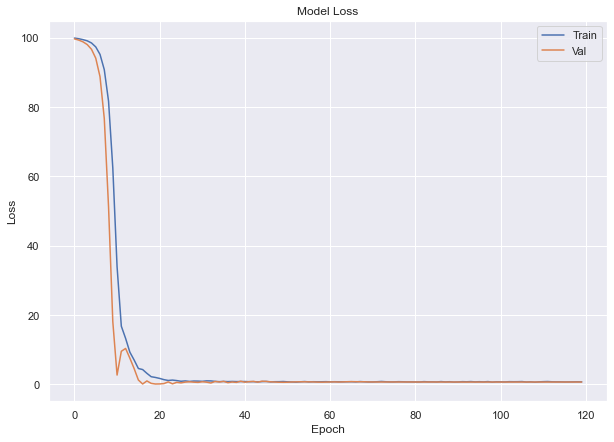

In [120]:
# Loss History
fig = plt.figure(figsize=(10, 7))
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

### Previsão Multistep 12 meses
Para ficar adequado à realidade, não podemos usar os dados de 2022 para prever 2022. Portanto, a previsão de 2022 será feita do moto *multistep*, isto é, o mês de janeiro/2022 será previsto usando-se os dados de arrecadação de janeiro a dezembro de 2021; o mês de fevereiro/2022 será previsto usando-se os dados de fevereiro a dezembro de 2021 mais a previsão feita para o mês de janeiro/2022; o mês de março/2022 será previsto usando-se os dados de março a dezembro de 2021 mais os meses de janeiro e fevereiro de 2022 previstos nos passos anteriores. E assim por diante, até que a previsão de dezembro/2022 será feita usando-se os dados de dezembro de 2021 mais as previsões de janeiro a novembro de 2022 feitas nos passos anteriores.

#### Remove os 12 últimos valores que serão previstos e cria as séries novamente

In [121]:
# remove
serie_multi1 = l_icms_ts[:-12]
print(l_icms_ts.shape)
print(serie_multi1.shape)

(156,)
(144,)


In [122]:
for i in range(12):
    # cria as séries
    X_multi1, Y_multi1 = cria_features_target(serie_multi1, verbose=0)

    # Faz a normalização usando o modelo fitado na normalização anterior
    X_multi_std1 = enc_x.transform(X_multi1)
    X_multi_std1 = X_multi_std1.reshape(X_multi_std1.shape[0],10,1)

    # Faz o janelamento das séries
    x_multi1, y_multi1 = janelamento_1_mes(X_multi_std1, Y_multi1, verbose=0)

    # Faz a predição da arrecadação do mês
    #y_pred_multi = np.mean(model.predict(x_multi[-1:]), axis=1)#[:,0].ravel()
    y_pred_multi1 = model.predict(x_multi1[-1:])#[:,0].ravel()
    print(i, np.exp(y_pred_multi1))

    #### Adicionar o valor previsto à série e fazer o novo janelamento
    serie_multi1 = pd.Series(np.append(serie_multi1, y_pred_multi1))

0 [[9.828204e+09]]
1 [[9.858149e+09]]
2 [[9.92329e+09]]
3 [[9.879457e+09]]
4 [[9.841672e+09]]
5 [[9.840096e+09]]
6 [[9.803696e+09]]
7 [[9.815297e+09]]
8 [[9.790933e+09]]
9 [[9.785052e+09]]
10 [[9.787162e+09]]
11 [[9.792222e+09]]


In [123]:
Y_pred_multi1 = np.exp(pd.Series(serie_multi1[-12:]))
Y_pred_multi1.index = icms_ts.index[-12:]

In [124]:
RMSE_lstm_multi1 = mean_squared_error(np.exp(y_test1), Y_pred_multi1, squared=False)
RMSE_lstm_multi1

566318328.3216171

In [125]:
MAPE_lstm_multi1 = mean_absolute_percentage_error(np.exp(y_test1), Y_pred_multi1)
MAPE_lstm_multi1

0.04120211190864511

In [126]:
previsoes['nome'].append('RNN-LSTM-1-mês')
previsoes['modelo'].append(model)
previsoes['previsoes'].append(Y_pred_multi1)

previsoes['rmse'].append(RMSE_lstm_multi1)

previsoes['mape'].append(MAPE_lstm_multi1)

previsoes['erro relativo'].append([erro_relativo(prev,real) 
                                   for prev,real in zip(Y_pred_multi1
                                                        , np.exp(y_test1))])

### Modelo 12 meses

#### Criando as janelas de 12 meses e reshape para LSTM. A arrecadação de cada mês será prevista pela arrecadação dos 12 meses anteriores.

##### Unindo novamente os dados.

In [127]:
def janelamento_12_meses(X, Y, verbose=0):
    X_exp = np.concatenate((np.roll(X, 12, axis=0),
                            np.roll(X, 11, axis=0),
                            np.roll(X, 10, axis=0),
                            np.roll(X, 9, axis=0),
                            np.roll(X, 8, axis=0),
                            np.roll(X, 7, axis=0),
                            np.roll(X, 6, axis=0),
                            np.roll(X, 5, axis=0),
                            np.roll(X, 4, axis=0),
                            np.roll(X, 3, axis=0),
                            np.roll(X, 2, axis=0),
                            np.roll(X, 1, axis=0),
                            ), axis=2)
    X_exp_cut = X_exp[12:,:,:].transpose(0,2,1)
    Y_cut = Y[12:]
    if verbose==1:
        print('shape das features janeladas:', X_exp.shape)
        print('shape das features janeladas pós poda e transposição:', X_exp_cut.shape)
        print('shape do array target pós poda:', Y_cut.shape)
    return X_exp_cut, Y_cut

In [128]:
X_data_exp_cut12, Y_data_cut12 = janelamento_12_meses(X_data_jn, Y_data, verbose=0)

In [129]:
#Y_data_cut[0]

In [130]:
#X_data_exp_cut[0]

In [131]:
#Y_data_cut[Y_data_cut.shape[0]-1]

In [132]:
#X_data_exp_cut[Y_data_cut.shape[0]-1]

#### Separando novamente em treino, validação e teste

In [133]:
x_train12 = X_data_exp_cut12[:-24]
x_val12 = X_data_exp_cut12[-24:-12]
x_test12 = X_data_exp_cut12[-12:]
print(x_train12.shape, x_val12.shape, x_test12.shape)
y_train12 = Y_data_cut12[:-24]
y_val12 = Y_data_cut12[-24:-12]
y_test12 = np.exp(Y_data_cut12[-12:]) # tirar o log para ficar o valor real
print(y_train12.shape, y_val12.shape, y_test12.shape)

(108, 12, 10) (12, 12, 10) (12, 12, 10)
(108,) (12,) (12,)


### Criando o modelo LSTM

In [134]:
rlrop2 = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=25, verbose=1)
early_stop2 = EarlyStopping(monitor='val_loss', patience=100, verbose=1, 
                           restore_best_weights=True)

#### Arquitetura da Rede

In [135]:
# Épocas e tamanho do lote
EPOCHS2 = 1000
BATCH2 = 8
NEURONIOS2 = 600
LR2 = 1e-5
DROPOUT2 = 0.25

# Imstanciação do modelo
model2 = Sequential()

# Adicionar camada LSTM 
model2.add(LSTM(activation='tanh', dropout=DROPOUT2,
        input_shape = (12, 10), return_sequences = True,
        units = NEURONIOS2))

# Adicionar camada LSTM 
model2.add(LSTM(activation='tanh', dropout=DROPOUT2,
        input_shape = (12, 10), return_sequences = True,
        units = NEURONIOS2))

## Adicionar camada LSTM 
model2.add(LSTM(activation='tanh', dropout=DROPOUT2,
        input_shape = (12, 10), return_sequences = False,
        units = NEURONIOS2))


# Adicionar a camada de saída com 1 neurônio linear
model2.add(Dense(
        units = 1,
        activation = 'linear'))
# a learning rate padrão do Adam é 0.001
model2.compile(loss = 'mape', optimizer = Adam(learning_rate=LR2))

In [136]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 12, 600)           1466400   
_________________________________________________________________
lstm_4 (LSTM)                (None, 12, 600)           2882400   
_________________________________________________________________
lstm_5 (LSTM)                (None, 600)               2882400   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 601       
Total params: 7,231,801
Trainable params: 7,231,801
Non-trainable params: 0
_________________________________________________________________


In [137]:
# History object for plotting our model loss by epoch
history2 = model2.fit(x_train12, y_train12, batch_size = BATCH2, 
                    epochs = EPOCHS2, validation_data = (x_val12, y_val12),
                    callbacks = [rlrop2, early_stop2])

Epoch 1/1000
14/14 [==============================] - 2s 165ms/step - loss: 99.7745 - val_loss: 98.9540
Epoch 2/1000
14/14 [==============================] - 1s 105ms/step - loss: 99.0990 - val_loss: 97.6184
Epoch 3/1000
14/14 [==============================] - 2s 108ms/step - loss: 98.2341 - val_loss: 95.6959
Epoch 4/1000
14/14 [==============================] - 2s 110ms/step - loss: 96.9182 - val_loss: 92.4850
Epoch 5/1000
14/14 [==============================] - 2s 112ms/step - loss: 94.6296 - val_loss: 86.4348
Epoch 6/1000
14/14 [==============================] - 2s 116ms/step - loss: 90.1568 - val_loss: 74.2683
Epoch 7/1000
14/14 [==============================] - 2s 118ms/step - loss: 80.9859 - val_loss: 51.8062
Epoch 8/1000
14/14 [==============================] - 2s 118ms/step - loss: 63.9219 - val_loss: 25.9845
Epoch 9/1000
14/14 [==============================] - 2s 119ms/step - loss: 41.8339 - val_loss: 8.1001
Epoch 10/1000
14/14 [==============================] - 2s 125ms/s

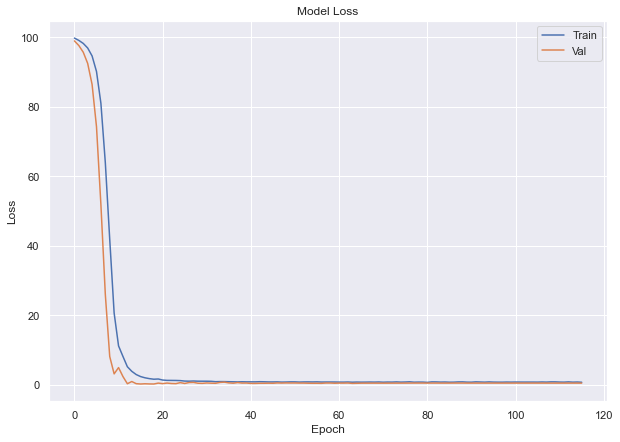

In [138]:
# Loss History
fig = plt.figure(figsize=(10, 7))
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

### Previsão Multistep 12 meses
Para ficar adequado à realidade, não podemos usar os dados de 2022 para prever 2022. Portanto, a previsão de 2022 será feita do moto *multistep*, isto é, o mês de janeiro/2022 será previsto usando-se os dados de arrecadação de janeiro a dezembro de 2021; o mês de fevereiro/2022 será previsto usando-se os dados de fevereiro a dezembro de 2021 mais a previsão feita para o mês de janeiro/2022; o mês de março/2022 será previsto usando-se os dados de março a dezembro de 2021 mais os meses de janeiro e fevereiro de 2022 previstos nos passos anteriores. E assim por diante, até que a previsão de dezembro/2022 será feita usando-se os dados de dezembro de 2021 mais as previsões de janeiro a novembro de 2022 feitas nos passos anteriores.

#### Remove os 12 últimos valores que serão previstos e cria as séries novamente

In [139]:
# remove
serie_multi12 = l_icms_ts[:-12]
print(l_icms_ts.shape)
print(serie_multi12.shape)
type(serie_multi12)

(156,)
(144,)


pandas.core.series.Series

In [140]:
for i in range(12):
    # cria as séries
    X_multi12, Y_multi12 = cria_features_target(serie_multi12, verbose=0)

    # Faz a normalização usando o modelo fitado na normalização anterior
    X_multi_std12 = enc_x.transform(X_multi12)
    X_multi_std12 = X_multi_std12.reshape(X_multi_std12.shape[0],10,1)

    # Faz o janelamento das séries
    x_multi12, y_multi12 = janelamento_12_meses(X_multi_std12, Y_multi12, verbose=0)

    # Faz a predição da arrecadação do mês
    #y_pred_multi = np.mean(model.predict(x_multi[-1:]), axis=1)#[:,0].ravel()
    y_pred_multi12 = model2.predict(x_multi12[-1:])#[:,0].ravel()
    print(i, np.exp(y_pred_multi12))

    #### Adicionar o valor previsto à série e fazer o novo janelamento
    serie_multi12 = pd.Series(np.append(serie_multi12, y_pred_multi12))
    type(serie_multi12)

0 [[1.008029e+10]]
1 [[1.0078847e+10]]
2 [[1.007658e+10]]
3 [[1.007658e+10]]
4 [[1.0078328e+10]]
5 [[1.0078482e+10]]
6 [[1.0082886e+10]]
7 [[1.0085232e+10]]
8 [[1.0090909e+10]]
9 [[1.0099475e+10]]
10 [[1.0109557e+10]]
11 [[1.0117639e+10]]


In [141]:
Y_pred_multi12 = np.exp(pd.Series(serie_multi12[-12:])) # tira o log das previsões
Y_pred_multi12.index = l_icms_ts.index[-12:]

In [142]:
Y_pred_multi12

date
2015-01-01    1.008029e+10
2015-02-01    1.007885e+10
2015-03-01    1.007658e+10
2015-04-01    1.007658e+10
2015-05-01    1.007833e+10
2015-06-01    1.007848e+10
2015-07-01    1.008289e+10
2015-08-01    1.008523e+10
2015-09-01    1.009091e+10
2015-10-01    1.009948e+10
2015-11-01    1.010956e+10
2015-12-01    1.011764e+10
dtype: float64

In [143]:
Y_pred_multi12

date
2015-01-01    1.008029e+10
2015-02-01    1.007885e+10
2015-03-01    1.007658e+10
2015-04-01    1.007658e+10
2015-05-01    1.007833e+10
2015-06-01    1.007848e+10
2015-07-01    1.008289e+10
2015-08-01    1.008523e+10
2015-09-01    1.009091e+10
2015-10-01    1.009948e+10
2015-11-01    1.010956e+10
2015-12-01    1.011764e+10
dtype: float64

In [144]:
RMSE_lstm_multi12 = mean_squared_error(y_test12, Y_pred_multi12, squared=False)
RMSE_lstm_multi12

389034330.33005846

In [145]:
MAPE_lstm_multi12 = mean_absolute_percentage_error(y_test12, Y_pred_multi12)
MAPE_lstm_multi12

0.030546434982276948

In [146]:
previsoes['nome'].append('RNN-LSTM-12-meses')
previsoes['modelo'].append(model2)
previsoes['previsoes'].append(Y_pred_multi12)

previsoes['rmse'].append(RMSE_lstm_multi12)

previsoes['mape'].append(MAPE_lstm_multi12)

In [147]:
previsoes['erro relativo'].append([erro_relativo(prev,real) 
                                   for prev,real in zip(Y_pred_multi12
                                                        , y_test12)])

In [148]:
previsoes['nome']

['Mean',
 'SARIMA(0,1,1),(1,0,1)',
 'SARIMAX(0,1,1),(1,0,1)',
 'Markov-Fixed',
 'Markov-Switching-Var',
 'Markov-Mean-Var',
 'RNN-LSTM-1-mês',
 'RNN-LSTM-12-meses']

## Resultados

In [149]:
df_prev = pd.DataFrame(data=previsoes['previsoes'], 
                       index=previsoes['nome']).transpose()
df_prev["real"] = icms_test
df_rmse = pd.DataFrame(data=previsoes['rmse'], 
                       index=previsoes['nome']).transpose()
df_mape = pd.DataFrame(data=previsoes['mape'], 
                       index=previsoes['nome']).transpose()
df_erro = pd.DataFrame(data=previsoes['erro relativo'], 
                       index=previsoes['nome']).transpose()

In [150]:
df_prev

,Mean,"SARIMA(0,1,1),(1,0,1)","SARIMAX(0,1,1),(1,0,1)",Markov-Fixed,Markov-Switching-Var,Markov-Mean-Var,RNN-LSTM-1-mês,RNN-LSTM-12-meses,real
2015-01-01,9.917198e+09,1.014584e+10,1.016678e+10,1.015299e+10,1.015288e+10,1.034930e+10,9.828204e+09,1.008029e+10,9.987825e+09
2015-02-01,9.917198e+09,9.931784e+09,1.002613e+10,9.929947e+09,9.867201e+09,9.863239e+09,9.858149e+09,1.007885e+10,9.919477e+09
2015-03-01,9.917198e+09,1.006162e+10,1.001289e+10,1.022763e+10,1.000460e+10,1.029537e+10,9.923290e+09,1.007658e+10,9.871727e+09
2015-04-01,9.917198e+09,1.042939e+10,1.031545e+10,1.057283e+10,1.048579e+10,1.064153e+10,9.879457e+09,1.007658e+10,1.037640e+10
2015-05-01,9.917198e+09,1.046458e+10,1.038969e+10,1.056222e+10,1.051246e+10,1.058740e+10,9.841673e+09,1.007833e+10,9.740006e+09
2015-06-01,9.917198e+09,1.040369e+10,1.025233e+10,1.065728e+10,1.057912e+10,1.071360e+10,9.840096e+09,1.007848e+10,1.032307e+10
2015-07-01,9.917198e+09,1.047142e+10,1.031148e+10,1.064873e+10,1.058757e+10,1.057784e+10,9.803696e+09,1.008289e+10,1.029487e+10
2015-08-01,9.917198e+09,1.055323e+10,1.030290e+10,1.085141e+10,1.079949e+10,1.084369e+10,9.815296e+09,1.008523e+10,9.864942e+09
2015-09-01,9.917198e+09,1.085996e+10,1.058810e+10,1.117332e+10,1.120277e+10,1.112272e+10,9.790933e+09,1.009091e+10,1.051019e+10
2015-10-01,9.917198e+09,1.123203e+10,1.107234e+10,1.136448e+10,1.139495e+10,1.140003e+10,9.785052e+09,1.009948e+10,1.056639e+10


In [151]:
df_erro

,Mean,"SARIMA(0,1,1),(1,0,1)","SARIMAX(0,1,1),(1,0,1)",Markov-Fixed,Markov-Switching-Var,Markov-Mean-Var,RNN-LSTM-1-mês,RNN-LSTM-12-meses
0,0.707130,1.582068,1.791706,1.653668,1.652571,3.619154,1.598160,0.925768
1,0.022969,0.124076,1.075239,0.105554,0.527004,0.566939,0.618257,1.606644
2,0.460627,1.923615,1.429941,3.605251,1.345958,4.291511,0.522332,2.075146
3,4.425439,0.510681,0.587415,1.893014,1.054258,2.555157,4.789164,2.889444
4,1.819225,7.439141,6.670260,8.441606,7.930730,8.700183,1.043806,3.473537
5,3.931699,0.780965,0.685224,3.237522,2.480348,3.783108,4.678595,2.369336
6,3.668560,1.714960,0.161340,3.437255,2.843192,2.748629,4.771072,2.059148
7,0.529714,6.977143,4.439494,9.999683,9.473444,9.921475,0.503256,2.233053
8,5.642056,3.327908,0.741249,6.309446,6.589642,5.827990,6.843417,3.989282
9,6.143904,6.299635,4.788337,7.553173,7.841477,7.889576,7.394531,4.418828


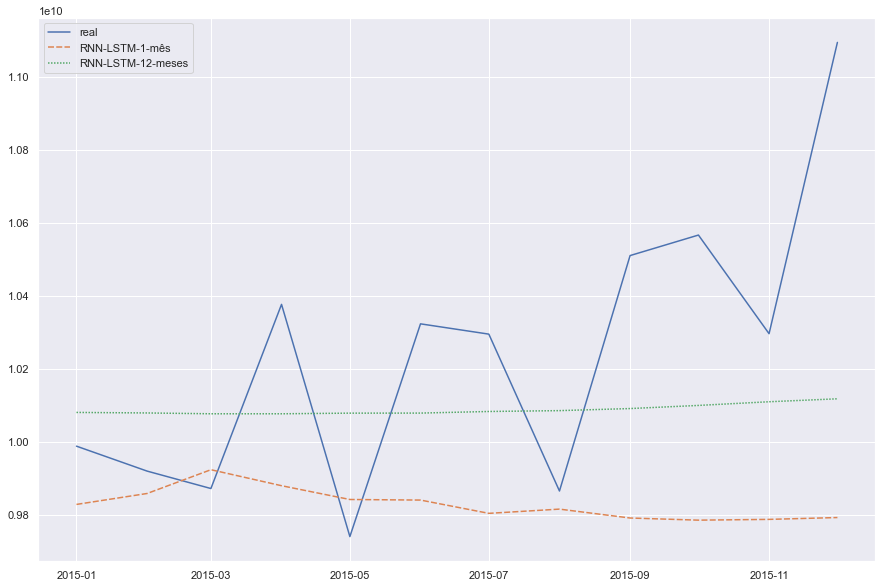

In [152]:
fig = plt.figure(figsize=(15, 10))
ax = sns.lineplot(data=df_prev[['real', 'RNN-LSTM-1-mês', 'RNN-LSTM-12-meses']])

#### Previsões

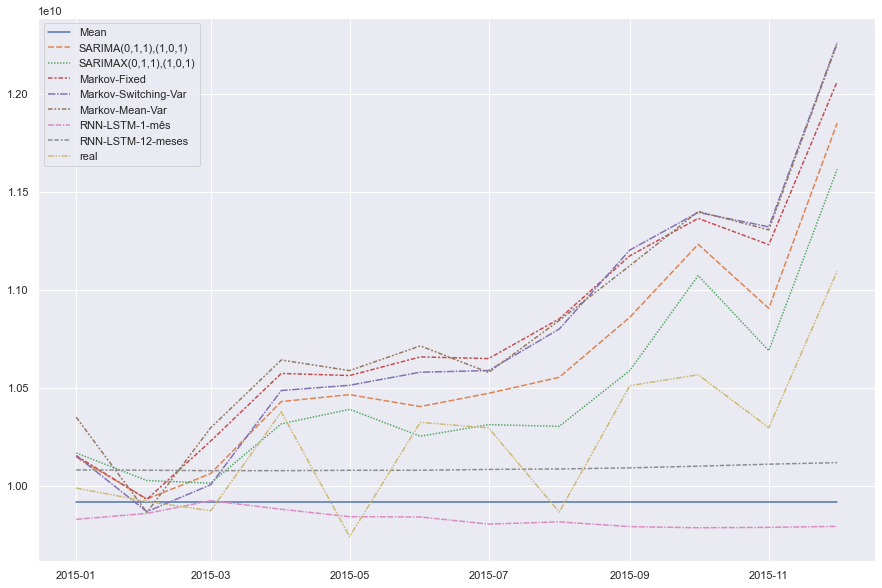

In [153]:
fig = plt.figure(figsize=(15, 10))
ax = sns.lineplot(data=df_prev)

#### RMSE

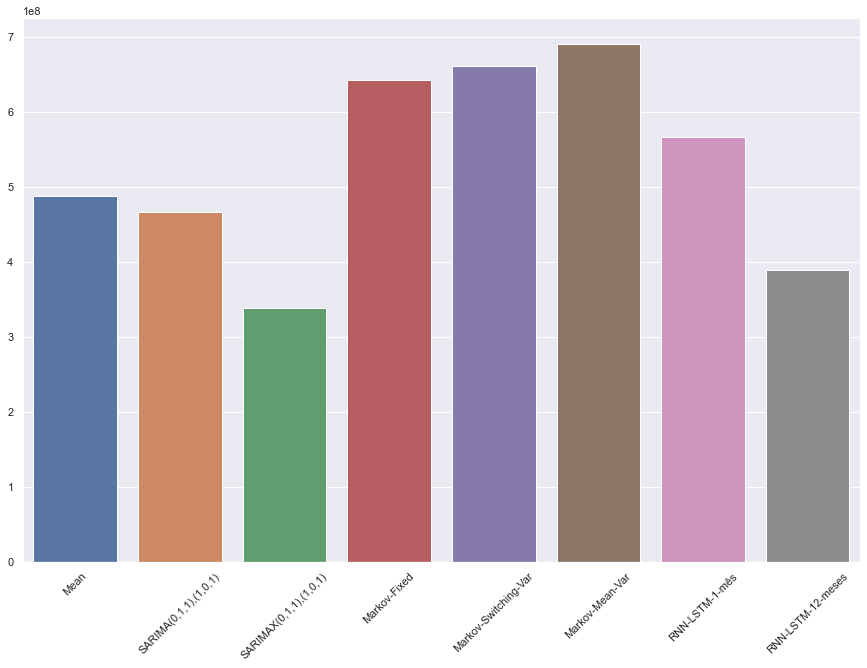

In [154]:
fig = plt.figure(figsize=(15, 10))
#df_rmse = df_rmse.drop(['mov_avg_12'], axis=1)
ax = sns.barplot(data=df_rmse)
_ = plt.xticks(rotation=45)

#### MAPE

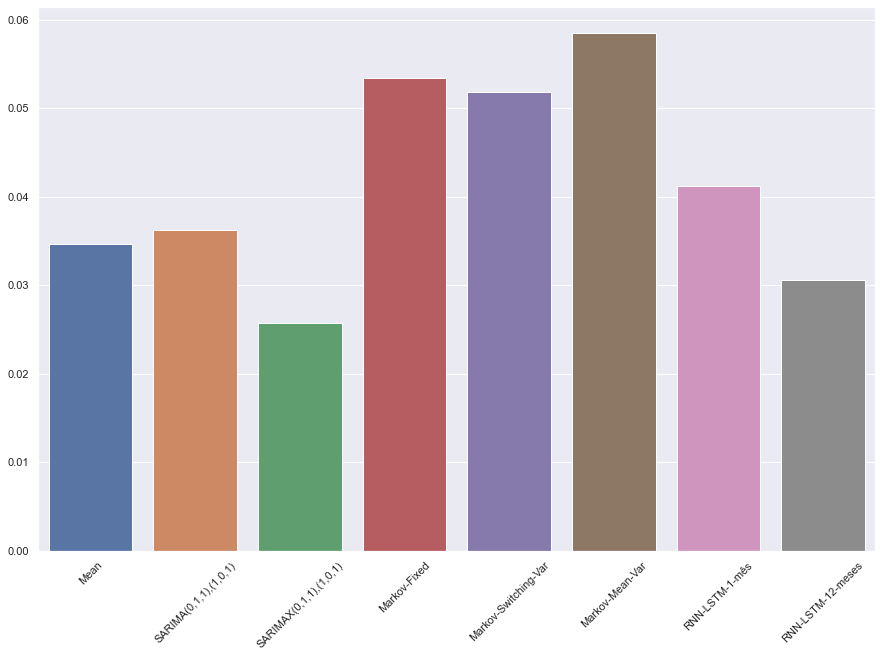

In [155]:
fig = plt.figure(figsize=(15, 10))
#df_mape = df_mape.drop(['mov_avg_12'], axis=1)
ax = sns.barplot(data=df_mape)
_ = plt.xticks(rotation=45)

### Resumo das métricas

In [156]:
df_rmse.index = ['RMSE']
df_mape.index = ['MAPE']

In [157]:
df_metricas = df_rmse.copy()
df_metricas = df_metricas.append(df_mape.copy())
df_metricas

,Mean,"SARIMA(0,1,1),(1,0,1)","SARIMAX(0,1,1),(1,0,1)",Markov-Fixed,Markov-Switching-Var,Markov-Mean-Var,RNN-LSTM-1-mês,RNN-LSTM-12-meses
RMSE,4.883489e+08,4.662930e+08,3.383003e+08,6.432671e+08,6.622544e+08,6.910122e+08,5.663183e+08,3.890343e+08
MAPE,3.470150e-02,3.617899e-02,2.573071e-02,5.336356e-02,5.185489e-02,5.847980e-02,4.120211e-02,3.054643e-02


In [158]:
print(df_metricas.transpose().to_latex())

\begin{tabular}{lrr}
\toprule
{} &          RMSE &      MAPE \\
\midrule
Mean                   &  4.883489e+08 &  0.034702 \\
SARIMA(0,1,1),(1,0,1)  &  4.662930e+08 &  0.036179 \\
SARIMAX(0,1,1),(1,0,1) &  3.383003e+08 &  0.025731 \\
Markov-Fixed           &  6.432671e+08 &  0.053364 \\
Markov-Switching-Var   &  6.622544e+08 &  0.051855 \\
Markov-Mean-Var        &  6.910122e+08 &  0.058480 \\
RNN-LSTM-1-mês         &  5.663183e+08 &  0.041202 \\
RNN-LSTM-12-meses      &  3.890343e+08 &  0.030546 \\
\bottomrule
\end{tabular}



In [159]:
print(df_prev['2015-01-01':'2015-04-01'].transpose().to_latex(escape=False))

\begin{tabular}{lrrrr}
\toprule
{} &    2015-01-01 &    2015-02-01 &    2015-03-01 &    2015-04-01 \\
\midrule
Mean                   &  9.917198e+09 &  9.917198e+09 &  9.917198e+09 &  9.917198e+09 \\
SARIMA(0,1,1),(1,0,1)  &  1.014584e+10 &  9.931784e+09 &  1.006162e+10 &  1.042939e+10 \\
SARIMAX(0,1,1),(1,0,1) &  1.016678e+10 &  1.002613e+10 &  1.001289e+10 &  1.031545e+10 \\
Markov-Fixed           &  1.015299e+10 &  9.929947e+09 &  1.022763e+10 &  1.057283e+10 \\
Markov-Switching-Var   &  1.015288e+10 &  9.867201e+09 &  1.000460e+10 &  1.048579e+10 \\
Markov-Mean-Var        &  1.034930e+10 &  9.863239e+09 &  1.029537e+10 &  1.064153e+10 \\
RNN-LSTM-1-mês         &  9.828204e+09 &  9.858149e+09 &  9.923290e+09 &  9.879457e+09 \\
RNN-LSTM-12-meses      &  1.008029e+10 &  1.007885e+10 &  1.007658e+10 &  1.007658e+10 \\
real                   &  9.987825e+09 &  9.919477e+09 &  9.871727e+09 &  1.037640e+10 \\
\bottomrule
\end{tabular}



In [160]:
print(df_prev['2015-05-01':'2015-08-01'].transpose().to_latex(escape=False))

\begin{tabular}{lrrrr}
\toprule
{} &    2015-05-01 &    2015-06-01 &    2015-07-01 &    2015-08-01 \\
\midrule
Mean                   &  9.917198e+09 &  9.917198e+09 &  9.917198e+09 &  9.917198e+09 \\
SARIMA(0,1,1),(1,0,1)  &  1.046458e+10 &  1.040369e+10 &  1.047142e+10 &  1.055323e+10 \\
SARIMAX(0,1,1),(1,0,1) &  1.038969e+10 &  1.025233e+10 &  1.031148e+10 &  1.030290e+10 \\
Markov-Fixed           &  1.056222e+10 &  1.065728e+10 &  1.064873e+10 &  1.085141e+10 \\
Markov-Switching-Var   &  1.051246e+10 &  1.057912e+10 &  1.058757e+10 &  1.079949e+10 \\
Markov-Mean-Var        &  1.058740e+10 &  1.071360e+10 &  1.057784e+10 &  1.084369e+10 \\
RNN-LSTM-1-mês         &  9.841673e+09 &  9.840096e+09 &  9.803696e+09 &  9.815296e+09 \\
RNN-LSTM-12-meses      &  1.007833e+10 &  1.007848e+10 &  1.008289e+10 &  1.008523e+10 \\
real                   &  9.740006e+09 &  1.032307e+10 &  1.029487e+10 &  9.864942e+09 \\
\bottomrule
\end{tabular}



In [161]:
print(df_prev['2015-09-01':'2015-12-01'].transpose().to_latex(escape=False))

\begin{tabular}{lrrrr}
\toprule
{} &    2015-09-01 &    2015-10-01 &    2015-11-01 &    2015-12-01 \\
\midrule
Mean                   &  9.917198e+09 &  9.917198e+09 &  9.917198e+09 &  9.917198e+09 \\
SARIMA(0,1,1),(1,0,1)  &  1.085996e+10 &  1.123203e+10 &  1.090511e+10 &  1.185095e+10 \\
SARIMAX(0,1,1),(1,0,1) &  1.058810e+10 &  1.107234e+10 &  1.068925e+10 &  1.161449e+10 \\
Markov-Fixed           &  1.117332e+10 &  1.136448e+10 &  1.123024e+10 &  1.206260e+10 \\
Markov-Switching-Var   &  1.120277e+10 &  1.139495e+10 &  1.132117e+10 &  1.226275e+10 \\
Markov-Mean-Var        &  1.112272e+10 &  1.140003e+10 &  1.130573e+10 &  1.225550e+10 \\
RNN-LSTM-1-mês         &  9.790933e+09 &  9.785052e+09 &  9.787161e+09 &  9.792222e+09 \\
RNN-LSTM-12-meses      &  1.009091e+10 &  1.009948e+10 &  1.010956e+10 &  1.011764e+10 \\
real                   &  1.051019e+10 &  1.056639e+10 &  1.029608e+10 &  1.109438e+10 \\
\bottomrule
\end{tabular}



In [164]:
df_metricas.transpose().to_excel('./metricas_uni_2015.xlsx', index_label='metrica')

In [165]:
df_prev.to_excel('./previsoes_uni_2015.xlsx', index_label='mes_ano')